# **Pure MCTS**

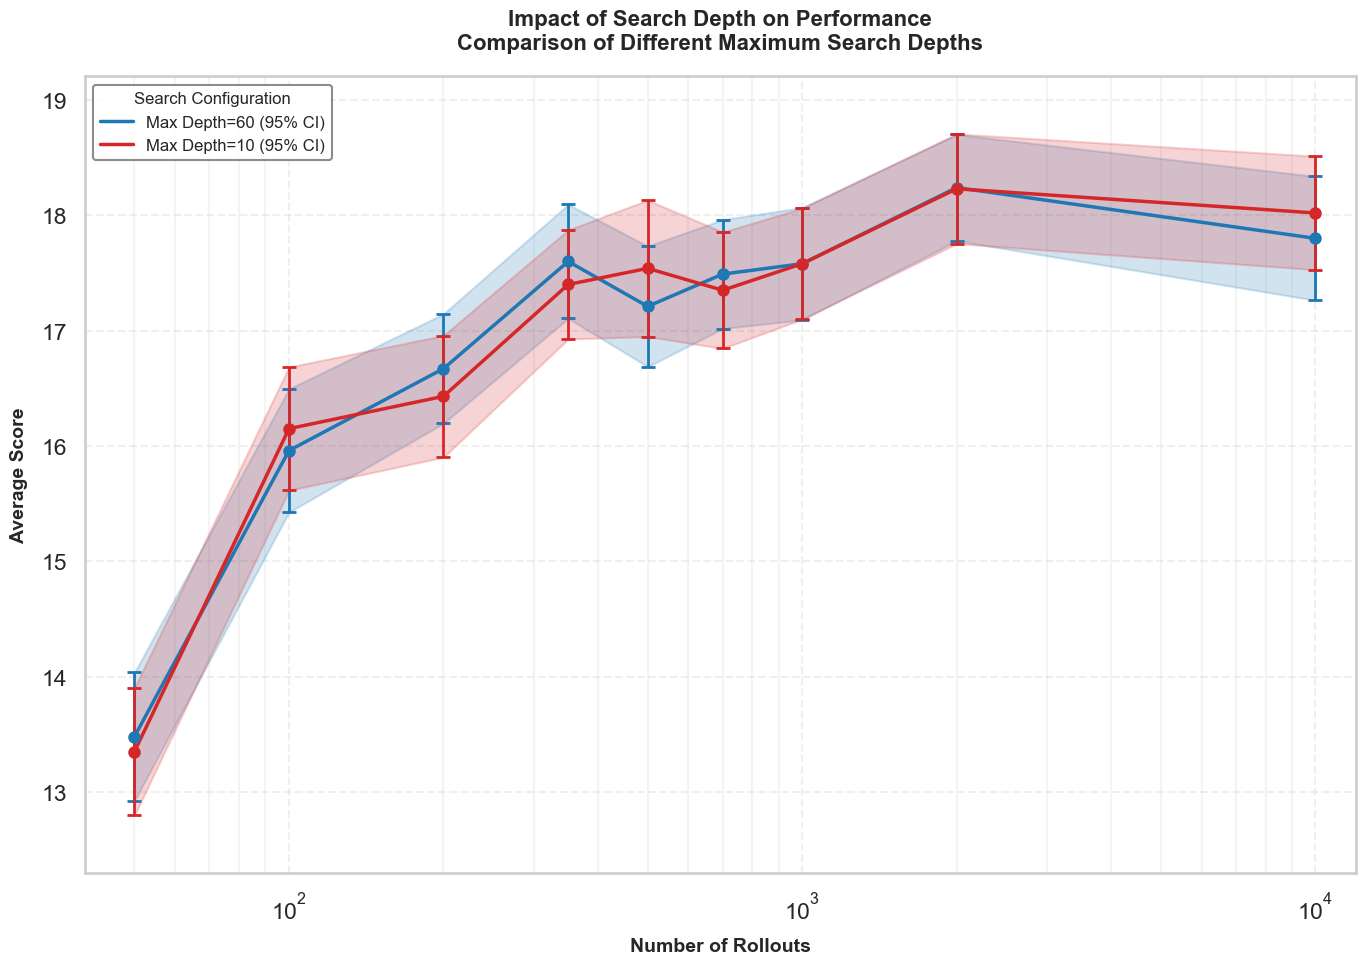

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import seaborn as sns


# Data
rollout_numbers = np.array([50, 100, 200, 350, 500, 700, 1000, 2000, 10000])
scores_depth60 = np.array([13.48, 15.96, 16.67, 17.6, 17.21, 17.49, 17.58, 18.24, 17.8])
se_depth60 = np.array(
    [0.2837, 0.2727, 0.2421, 0.2519, 0.2666, 0.2410, 0.2483, 0.2350, 0.2739]
)
scores_depth10 = np.array(
    [13.35, 16.15, 16.43, 17.4, 17.54, 17.35, 17.58, 18.23, 18.02]
)
se_depth10 = np.array(
    [0.2819, 0.2729, 0.2692, 0.2412, 0.3018, 0.2574, 0.2454, 0.2428, 0.2510]
)

# Convert SE to 95% CI (multiply by 1.96 for normal distribution)
ci_depth60 = 1.96 * se_depth60
ci_depth10 = 1.96 * se_depth10

# Interpolation in log space
log_rollouts = np.log(rollout_numbers)
log_rollouts_fine = np.linspace(log_rollouts.min(), log_rollouts.max(), 500)
rollouts_fine = np.exp(log_rollouts_fine)

# Interpolate scores
spline_depth60 = make_interp_spline(log_rollouts, scores_depth60, k=1)
scores_depth60_smooth = spline_depth60(log_rollouts_fine)
spline_depth10 = make_interp_spline(log_rollouts, scores_depth10, k=1)
scores_depth10_smooth = spline_depth10(log_rollouts_fine)

# Compute confidence intervals
upper_depth60 = scores_depth60 + ci_depth60
lower_depth60 = scores_depth60 - ci_depth60
upper_depth10 = scores_depth10 + ci_depth10
lower_depth10 = scores_depth10 - ci_depth10

# Interpolate confidence intervals
spline_upper_depth60 = make_interp_spline(log_rollouts, upper_depth60, k=1)
spline_lower_depth60 = make_interp_spline(log_rollouts, lower_depth60, k=1)
upper_depth60_smooth = spline_upper_depth60(log_rollouts_fine)
lower_depth60_smooth = spline_lower_depth60(log_rollouts_fine)

spline_upper_depth10 = make_interp_spline(log_rollouts, upper_depth10, k=1)
spline_lower_depth10 = make_interp_spline(log_rollouts, lower_depth10, k=1)
upper_depth10_smooth = spline_upper_depth10(log_rollouts_fine)
lower_depth10_smooth = spline_lower_depth10(log_rollouts_fine)

# Create figure
plt.figure(figsize=(14, 10))

# Set the style for a professional look
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

# Plot confidence interval regions
plt.fill_between(
    rollouts_fine,
    lower_depth60_smooth,
    upper_depth60_smooth,
    alpha=0.2,
    color="#1f77b4",
)
plt.fill_between(
    rollouts_fine,
    lower_depth10_smooth,
    upper_depth10_smooth,
    alpha=0.2,
    color="#d62728",
)

# Plot interpolated lines
plt.plot(
    rollouts_fine,
    scores_depth60_smooth,
    label="Max Depth=60 (95% CI)",
    color="#1f77b4",
    linewidth=2.5,
)
plt.plot(
    rollouts_fine,
    scores_depth10_smooth,
    label="Max Depth=10 (95% CI)",
    color="#d62728",
    linewidth=2.5,
)

# Plot data points with error bars
plt.errorbar(
    rollout_numbers,
    scores_depth60,
    yerr=ci_depth60,
    fmt="o",
    capsize=5,
    color="#1f77b4",
    markersize=8,
    elinewidth=2,
    capthick=2,
)
plt.errorbar(
    rollout_numbers,
    scores_depth10,
    yerr=ci_depth10,
    fmt="o",
    capsize=5,
    color="#d62728",
    markersize=8,
    elinewidth=2,
    capthick=2,
)

# Customize axes
plt.xscale("log")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel("Number of Rollouts", fontsize=14, fontweight="bold", labelpad=10)
plt.ylabel("Average Score", fontsize=14, fontweight="bold", labelpad=10)
plt.title(
    "Impact of Search Depth on Performance\nComparison of Different Maximum Search Depths",
    fontsize=16,
    fontweight="bold",
    pad=20,
)

# Customize legend
plt.legend(
    title="Search Configuration",
    title_fontsize=12,
    fontsize=12,
    loc="upper left",
    frameon=True,
    framealpha=0.9,
    edgecolor="gray",
)

# Set axis limits with some padding
plt.xlim(40, 12000)
ymin = min(min(lower_depth60_smooth), min(lower_depth10_smooth)) - 0.5
ymax = max(max(upper_depth60_smooth), max(upper_depth10_smooth)) + 0.5
plt.ylim(ymin, ymax)

# Add grid but make it subtle
plt.grid(True, alpha=0.3, linestyle="--")

# Adjust layout
plt.tight_layout()
plt.show()

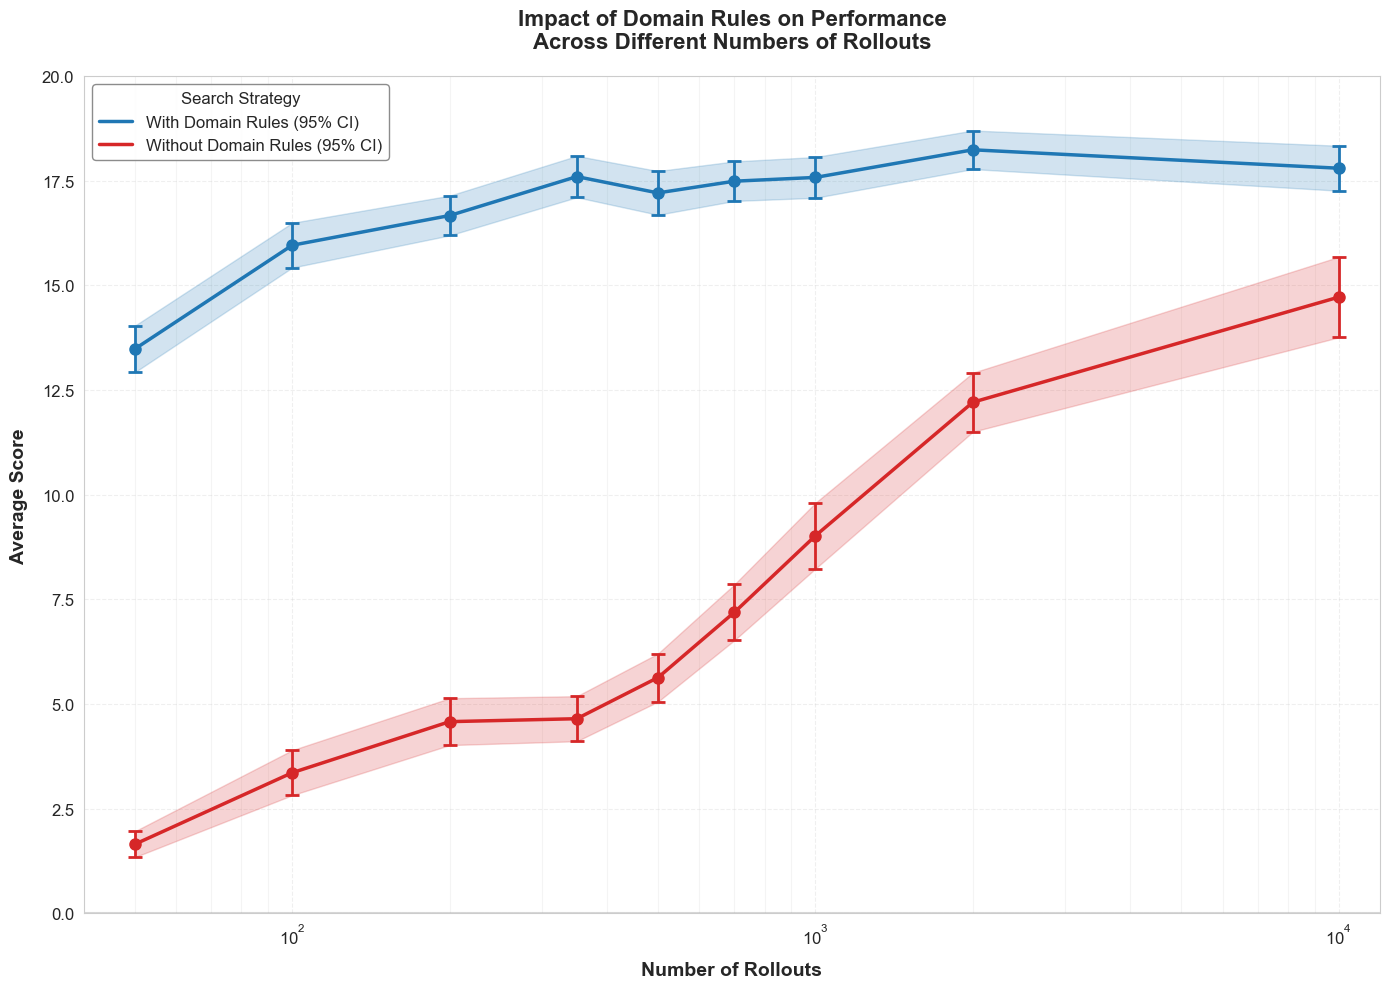

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import seaborn as sns


# Data
rollout_numbers = np.array([50, 100, 200, 350, 500, 700, 1000, 2000, 10000])

scores_with_rules = np.array(
    [13.48, 15.96, 16.67, 17.6, 17.21, 17.49, 17.58, 18.24, 17.8]
)
se_with_rules = np.array(
    [0.2837, 0.2727, 0.2421, 0.2519, 0.2666, 0.2410, 0.2483, 0.2350, 0.2739]
)

scores_without_rules = np.array(
    [1.65, 3.36, 4.58, 4.65, 5.63, 7.19, 9.02, 12.21, 14.72]
)
se_without_rules = np.array(
    [0.1577, 0.2744, 0.2857, 0.2744, 0.2931, 0.3399, 0.4010, 0.3595, 0.4901]
)

# Convert SE to 95% CI
ci_with_rules = 1.96 * se_with_rules
ci_without_rules = 1.96 * se_without_rules

# Interpolation in log space
log_rollouts = np.log(rollout_numbers)
log_rollouts_fine = np.linspace(log_rollouts.min(), log_rollouts.max(), 500)
rollouts_fine = np.exp(log_rollouts_fine)

# Interpolate scores
spline_with_rules = make_interp_spline(log_rollouts, scores_with_rules, k=1)
scores_with_rules_smooth = spline_with_rules(log_rollouts_fine)
spline_without_rules = make_interp_spline(log_rollouts, scores_without_rules, k=1)
scores_without_rules_smooth = spline_without_rules(log_rollouts_fine)

# Compute confidence intervals
upper_with_rules = scores_with_rules + ci_with_rules
lower_with_rules = scores_with_rules - ci_with_rules
upper_without_rules = scores_without_rules + ci_without_rules
lower_without_rules = scores_without_rules - ci_without_rules

# Interpolate confidence intervals
spline_upper_with_rules = make_interp_spline(log_rollouts, upper_with_rules, k=1)
spline_lower_with_rules = make_interp_spline(log_rollouts, lower_with_rules, k=1)
upper_with_rules_smooth = spline_upper_with_rules(log_rollouts_fine)
lower_with_rules_smooth = spline_lower_with_rules(log_rollouts_fine)

spline_upper_without_rules = make_interp_spline(log_rollouts, upper_without_rules, k=1)
spline_lower_without_rules = make_interp_spline(log_rollouts, lower_without_rules, k=1)
upper_without_rules_smooth = spline_upper_without_rules(log_rollouts_fine)
lower_without_rules_smooth = spline_lower_without_rules(log_rollouts_fine)

# Create figure
plt.figure(figsize=(14, 10))

# Set the style for a professional look
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

# Plot confidence interval regions
plt.fill_between(
    rollouts_fine,
    lower_with_rules_smooth,
    upper_with_rules_smooth,
    alpha=0.2,
    color="#1f77b4",
)
plt.fill_between(
    rollouts_fine,
    lower_without_rules_smooth,
    upper_without_rules_smooth,
    alpha=0.2,
    color="#d62728",
)

# Plot interpolated lines
plt.plot(
    rollouts_fine,
    scores_with_rules_smooth,
    label="With Domain Rules (95% CI)",
    color="#1f77b4",
    linewidth=2.5,
)
plt.plot(
    rollouts_fine,
    scores_without_rules_smooth,
    label="Without Domain Rules (95% CI)",
    color="#d62728",
    linewidth=2.5,
)

# Plot data points with error bars
plt.errorbar(
    rollout_numbers,
    scores_with_rules,
    yerr=ci_with_rules,
    fmt="o",
    capsize=5,
    color="#1f77b4",
    markersize=8,
    elinewidth=2,
    capthick=2,
)
plt.errorbar(
    rollout_numbers,
    scores_without_rules,
    yerr=ci_without_rules,
    fmt="o",
    capsize=5,
    color="#d62728",
    markersize=8,
    elinewidth=2,
    capthick=2,
)

# Customize axes
plt.xscale("log")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel("Number of Rollouts", fontsize=14, fontweight="bold", labelpad=10)
plt.ylabel("Average Score", fontsize=14, fontweight="bold", labelpad=10)
plt.title(
    "Impact of Domain Rules on Performance\nAcross Different Numbers of Rollouts",
    fontsize=16,
    fontweight="bold",
    pad=20,
)

# Set y-axis limits to highlight the difference
plt.ylim(0, 20)

# Add horizontal lines for context
plt.axhline(y=0, color="gray", linestyle="-", alpha=0.3)

# Customize legend
plt.legend(
    title="Search Strategy",
    title_fontsize=12,
    fontsize=12,
    loc="upper left",
    frameon=True,
    framealpha=0.9,
    edgecolor="gray",
)

# Set x-axis limits with some padding
plt.xlim(40, 12000)

# Add grid but make it subtle
plt.grid(True, alpha=0.3, linestyle="--")

# Add tick parameters
plt.tick_params(axis="both", which="major", labelsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

In [3]:
import json
import os
from typing import List, Tuple

# Initialize moves list - moved outside to be reused
moves = [
    {"action_type": "DISCARD", "card_index": 0},
    {"action_type": "DISCARD", "card_index": 1},
    {"action_type": "DISCARD", "card_index": 2},
    {"action_type": "DISCARD", "card_index": 3},
    {"action_type": "DISCARD", "card_index": 4},
    {"action_type": "PLAY", "card_index": 0},
    {"action_type": "PLAY", "card_index": 1},
    {"action_type": "PLAY", "card_index": 2},
    {"action_type": "PLAY", "card_index": 3},
    {"action_type": "PLAY", "card_index": 4},
    {"action_type": "REVEAL_COLOR", "target_offset": 1, "color": "R"},
    {"action_type": "REVEAL_COLOR", "target_offset": 1, "color": "Y"},
    {"action_type": "REVEAL_COLOR", "target_offset": 1, "color": "G"},
    {"action_type": "REVEAL_COLOR", "target_offset": 1, "color": "W"},
    {"action_type": "REVEAL_COLOR", "target_offset": 1, "color": "B"},
    {"action_type": "REVEAL_RANK", "target_offset": 1, "rank": 0},
    {"action_type": "REVEAL_RANK", "target_offset": 1, "rank": 1},
    {"action_type": "REVEAL_RANK", "target_offset": 1, "rank": 2},
    {"action_type": "REVEAL_RANK", "target_offset": 1, "rank": 3},
    {"action_type": "REVEAL_RANK", "target_offset": 1, "rank": 4},
]

# Pre-compile move descriptions for reuse
MOVE_DESCRIPTIONS = {}
for i, move in enumerate(moves):
    if move["action_type"] in ["DISCARD", "PLAY"]:
        MOVE_DESCRIPTIONS[i] = f"{move['action_type']} card {move['card_index'] + 1}"
    elif move["action_type"] == "REVEAL_COLOR":
        MOVE_DESCRIPTIONS[i] = f"Reveal {move['color']} to P{move['target_offset']}"
    elif move["action_type"] == "REVEAL_RANK":
        MOVE_DESCRIPTIONS[i] = f"Reveal {move['rank'] + 1} to P{move['target_offset']}"
    else:
        MOVE_DESCRIPTIONS[i] = f"Unknown: {move['action_type']}"


def process_game_states(data: List[Tuple]) -> None:
    """Process MCTS game states and write to output file efficiently."""
    os.makedirs("policies", exist_ok=True)

    with open("policies/mcts_50.md", "w") as output_file:
        for idx, (encoded_obs_list, policy_list, final_score) in enumerate(data):
            game_state_str = reconstruct_game_state(encoded_obs_list)

            # Calculate max probability and index
            max_prob = max(policy_list)
            max_prob_indices = [
                i for i, prob in enumerate(policy_list) if prob == max_prob
            ]

            # Write header and game state
            output_file.write(f"# Game State {idx+1}\n\n")
            output_file.write("## Game State\n")
            output_file.write(f"```\n{game_state_str}\n```\n\n")
            output_file.write("## MCTS Policy\n\n")
            output_file.write("|      Action       | Probability | Selected |\n")
            output_file.write("|:-----------------:|:-----------:|:--------:|\n")

            # Process moves with non-zero probability
            for i, prob in enumerate(policy_list):
                if prob > 0:
                    move_desc = f"{MOVE_DESCRIPTIONS[i]:<17}"
                    marker = "★" if i in max_prob_indices else ""
                    marker = f"{marker:^10}"
                    output_file.write(f"| {move_desc} |    {prob:.3f}    |{marker}|\n")

            output_file.write(f"\nFinal Score: {final_score:.3f}\n")
            output_file.write("\n---\n\n")


# Main execution
if __name__ == "__main__":
    data = []
    # Read and parse data from JSONL file using a buffer
    with open("policies/mcts.jsonl", "r", buffering=1024 * 1024) as file:  # 1MB buffer
        for line in file:
            json_data = json.loads(line)
            data.extend(
                (tuple_data[0], tuple_data[1], tuple_data[2])
                for tuple_data in json_data
            )

    process_game_states(data)
    print("Analysis complete! Results saved in 'policies/mcts_50.md'")

Analysis complete! Results saved in 'policies/mcts_50.md'


# **AlphaZero**

In [5]:
def reconstruct_game_state(encoded_obs):
    # Define game parameters
    num_colors = 5  # R, Y, G, W, B
    num_ranks = 5  # 1 to 5
    num_players = 2
    hand_size = 5
    bits_per_card = num_colors * num_ranks  # 25
    max_deck_size = 50
    max_information_tokens = 8
    max_life_tokens = 3

    # Helper functions
    def card_index(color, rank):
        return color * num_ranks + rank

    def get_color_rank_from_index(index):
        color = index // num_ranks
        rank = index % num_ranks
        return color, rank

    colors = ["R", "Y", "G", "W", "B"]
    ranks = ["1", "2", "3", "4", "5"]

    # Initialize offsets
    offset = 0
    encoding = encoded_obs

    # --- Hands Section ---
    hands_section_length = (num_players - 1) * hand_size * bits_per_card + num_players
    hands = []
    hand_sizes = [hand_size] * num_players  # Initialize hand sizes for all players

    # Other players' hands
    for player in range(1, num_players):
        player_hand = []
        num_cards_in_hand = hand_size
        for card_idx in range(num_cards_in_hand):
            card_offset = offset + card_idx * bits_per_card
            card_bits = encoding[card_offset : card_offset + bits_per_card]
            if any(card_bits):
                card_pos = card_bits.index(1)
                color_idx, rank_idx = get_color_rank_from_index(card_pos)
                card_str = f"{colors[color_idx]}{ranks[rank_idx]}"
            else:
                card_str = "XX"
            player_hand.append(card_str)
        hands.append(player_hand)

    offset += (num_players - 1) * hand_size * bits_per_card

    # Missing card indicators
    missing_card_bits = encoding[offset : offset + num_players]
    missing_cards = [bool(bit) for bit in missing_card_bits]
    offset += num_players

    # Adjust hand sizes based on missing cards
    for idx, missing in enumerate(missing_cards):
        if missing:
            hand_sizes[idx] -= 1  # Assume one card is missing

    # --- Board Section ---
    # Deck size (thermometer encoding)
    deck_size_bits = encoding[
        offset : offset + (max_deck_size - num_players * hand_size)
    ]
    deck_size = sum(deck_size_bits)
    offset += max_deck_size - num_players * hand_size

    # Fireworks
    fireworks = []
    for color_idx in range(num_colors):
        firework_bits = encoding[offset : offset + num_ranks]
        if any(firework_bits):
            highest_rank = firework_bits.index(1) + 1  # Ranks are 1-indexed
        else:
            highest_rank = 0
        fireworks.append(f"{colors[color_idx]}{highest_rank}")
        offset += num_ranks

    # Information tokens (thermometer encoding)
    info_token_bits = encoding[offset : offset + max_information_tokens]
    info_tokens = sum(info_token_bits)
    offset += max_information_tokens

    # Life tokens (thermometer encoding)
    life_token_bits = encoding[offset : offset + max_life_tokens]
    life_tokens = sum(life_token_bits)
    offset += max_life_tokens

    # --- Discards Section ---
    discard_bits = encoding[offset : offset + max_deck_size]
    offset += max_deck_size

    # Reconstruct discard pile
    discards = []
    idx_in_discard = 0
    for color_idx in range(num_colors):
        for rank_idx in range(num_ranks):
            num_instances = 0
            if rank_idx == 0:
                num_instances = 3
            elif rank_idx == 4:
                num_instances = 1
            else:
                num_instances = 2
            for i in range(num_instances):
                if discard_bits[idx_in_discard] == 1:
                    discards.append(f"{colors[color_idx]}{ranks[rank_idx]}")
                idx_in_discard += 1

    # --- Last Action Section ---
    last_action_section_length = (
        num_players
        + 4
        + num_players
        + num_colors
        + num_ranks
        + hand_size
        + hand_size
        + bits_per_card
        + 2
    )
    offset += last_action_section_length

    # --- Card Knowledge Section ---
    card_knowledge_section_length = (
        num_players * hand_size * (bits_per_card + num_colors + num_ranks)
    )
    card_knowledge = []

    for player in range(num_players):
        player_card_knowledge = []
        num_cards_in_hand = hand_sizes[player]
        for card_idx in range(hand_size):
            if card_idx >= num_cards_in_hand:
                # Skip missing cards
                offset += bits_per_card + num_colors + num_ranks
                continue

            # Plausible cards
            plausible_cards_bits = encoding[offset : offset + bits_per_card]
            offset += bits_per_card

            # Revealed colors
            revealed_color_bits = encoding[offset : offset + num_colors]
            offset += num_colors

            # Revealed ranks
            revealed_rank_bits = encoding[offset : offset + num_ranks]
            offset += num_ranks

            # Determine plausible colors and ranks
            plausible_colors = set()
            plausible_ranks = set()
            for idx_pc, bit in enumerate(plausible_cards_bits):
                if bit == 1:
                    color_idx, rank_idx = get_color_rank_from_index(idx_pc)
                    plausible_colors.add(colors[color_idx])
                    plausible_ranks.add(ranks[rank_idx])

            # Determine explicitly revealed colors and ranks
            revealed_colors = [
                colors[i] for i, bit in enumerate(revealed_color_bits) if bit == 1
            ]
            revealed_ranks = [
                ranks[i] for i, bit in enumerate(revealed_rank_bits) if bit == 1
            ]

            card_knowledge_entry = {
                "plausible_colors": plausible_colors,
                "plausible_ranks": plausible_ranks,
                "revealed_colors": revealed_colors,
                "revealed_ranks": revealed_ranks,
            }
            player_card_knowledge.append(card_knowledge_entry)

        card_knowledge.append(player_card_knowledge)

    # --- Construct Output String ---
    output = []

    output.append(f"Information Tokens: {info_tokens}")
    output.append(f"Life Tokens: {life_tokens}")
    output.append("Fireworks: " + " ".join(fireworks))
    output.append(f"Deck size: {deck_size}")
    output.append("Discards:")
    if discards:
        output.append(" ".join(discards))
    else:
        output.append("None")

    output.append("\nHands:")
    # Your hand with card knowledge
    output.append("Your hand:")
    your_hand_str = []
    for card_idx in range(hand_size):
        if card_idx >= len(card_knowledge[0]):
            continue  # Skip missing cards

        card_knowledge_entry = card_knowledge[0][card_idx]  # Our own hand is player 0

        # Determine known color and rank
        known_color = "X"
        if len(card_knowledge_entry["revealed_colors"]) == 1:
            known_color = card_knowledge_entry["revealed_colors"][0]

        known_rank = "X"
        if len(card_knowledge_entry["revealed_ranks"]) == 1:
            known_rank = card_knowledge_entry["revealed_ranks"][0]

        # Build plausible colors and ranks strings
        plausible_colors_str = "".join(
            sorted(
                card_knowledge_entry["plausible_colors"], key=lambda x: colors.index(x)
            )
        )
        plausible_ranks_str = "".join(
            sorted(
                card_knowledge_entry["plausible_ranks"], key=lambda x: ranks.index(x)
            )
        )

        # If no plausible colors or ranks, show all
        if not plausible_colors_str:
            plausible_colors_str = "".join(colors)
        if not plausible_ranks_str:
            plausible_ranks_str = "".join(ranks)

        # Format the card knowledge as per your requirement
        card_str = (
            f"{known_color}{known_rank} || {plausible_colors_str}{plausible_ranks_str}"
        )
        your_hand_str.append(card_str)

    output.extend(your_hand_str)

    # Other player's hand
    output.append("\nOther player's hand:")
    other_hand = hands[0]
    other_hand_str = " ".join(other_hand)
    if missing_cards[1]:
        other_hand_str += " (missing cards)"
    output.append(other_hand_str)

    # Return the output string
    return "\n".join(output)

In [6]:
import json
import os
from typing import List, Tuple

moves = [
    {'action_type': 'DISCARD', 'card_index': 0},
    {'action_type': 'DISCARD', 'card_index': 1},
    {'action_type': 'DISCARD', 'card_index': 2},
    {'action_type': 'DISCARD', 'card_index': 3},
    {'action_type': 'DISCARD', 'card_index': 4},
    {'action_type': 'PLAY', 'card_index': 0},
    {'action_type': 'PLAY', 'card_index': 1},
    {'action_type': 'PLAY', 'card_index': 2},
    {'action_type': 'PLAY', 'card_index': 3},
    {'action_type': 'PLAY', 'card_index': 4},
    {'action_type': 'REVEAL_COLOR', 'target_offset': 1, 'color': 'R'},
    {'action_type': 'REVEAL_COLOR', 'target_offset': 1, 'color': 'Y'},
    {'action_type': 'REVEAL_COLOR', 'target_offset': 1, 'color': 'G'},
    {'action_type': 'REVEAL_COLOR', 'target_offset': 1, 'color': 'W'},
    {'action_type': 'REVEAL_COLOR', 'target_offset': 1, 'color': 'B'},
    {'action_type': 'REVEAL_RANK', 'target_offset': 1, 'rank': 0},
    {'action_type': 'REVEAL_RANK', 'target_offset': 1, 'rank': 1},
    {'action_type': 'REVEAL_RANK', 'target_offset': 1, 'rank': 2},
    {'action_type': 'REVEAL_RANK', 'target_offset': 1, 'rank': 3},
    {'action_type': 'REVEAL_RANK', 'target_offset': 1, 'rank': 4},
]

MOVE_DESCRIPTIONS = {}
for i, move in enumerate(moves):
    if move['action_type'] in ['DISCARD', 'PLAY']:
        MOVE_DESCRIPTIONS[i] = f"{move['action_type']} card {move['card_index'] + 1}"
    elif move['action_type'] == 'REVEAL_COLOR':
        MOVE_DESCRIPTIONS[i] = f"Reveal {move['color']} to P{move['target_offset']}"  # Removed trailing comma
    elif move['action_type'] == 'REVEAL_RANK':
        MOVE_DESCRIPTIONS[i] = f"Reveal {move['rank'] + 1} to P{move['target_offset']}"  # Removed trailing comma
    else:
        MOVE_DESCRIPTIONS[i] = f"Unknown: {move['action_type']}"  # Removed trailing comma

def process_game_states(data: List[Tuple]) -> None:
    os.makedirs("policies", exist_ok=True)
    with open('policies/mcts_400.md', 'w') as output_file:
        for idx, (encoded_obs_list, policy_list, final_score) in enumerate(data):
            game_state_str = reconstruct_game_state(encoded_obs_list)
            
            # Calculate max probability and index
            max_prob = max(policy_list)
            max_prob_indices = [i for i, prob in enumerate(policy_list) if prob == max_prob]
            
            # Write header and game state
            output_file.write(f"# Game State {idx+1}\n\n")
            output_file.write(f"## Game State\n")
            output_file.write(f"```\n{game_state_str}\n```\n\n")
            output_file.write("## MCTS Policy\n\n")
            output_file.write("|      Action       | Probability | Selected |\n")
            output_file.write("|:-----------------:|:-----------:|:--------:|\n")
            
            # Process moves with non-zero probability
            for i, prob in enumerate(policy_list):
                if prob > 0:
                    move_desc = f"{MOVE_DESCRIPTIONS[i]:<17}"
                    marker = "★" if i in max_prob_indices else ""
                    marker = f"{marker:^10}"
                    output_file.write(f"| {move_desc} |    {prob:.3f}    |{marker}|\n")
            
            output_file.write(f"\nFinal Score: {final_score:.3f}\n")
            output_file.write("\n---\n\n")

if __name__ == "__main__":
    data = []
    # Read and parse data from JSONL file using a buffer
    with open('policies/mcts.jsonl', 'r', buffering=1024*1024) as file:  # 1MB buffer
        for line in file:
            json_data = json.loads(line)
            data.extend((tuple_data[0], tuple_data[1], tuple_data[2]) for tuple_data in json_data)
    
    process_game_states(data)
    print("Analysis complete! Results saved in 'policies/mcts_400.md'")

Analysis complete! Results saved in 'policies/mcts_400.md'


In [3]:
import json
import os
from typing import List, Tuple
from itertools import compress

# Initialize moves list - moved outside to be reused
moves = [
    {"action_type": "DISCARD", "card_index": 0},
    {"action_type": "DISCARD", "card_index": 1},
    {"action_type": "DISCARD", "card_index": 2},
    {"action_type": "DISCARD", "card_index": 3},
    {"action_type": "DISCARD", "card_index": 4},
    {"action_type": "PLAY", "card_index": 0},
    {"action_type": "PLAY", "card_index": 1},
    {"action_type": "PLAY", "card_index": 2},
    {"action_type": "PLAY", "card_index": 3},
    {"action_type": "PLAY", "card_index": 4},
    {"action_type": "REVEAL_COLOR", "target_offset": 1, "color": "R"},
    {"action_type": "REVEAL_COLOR", "target_offset": 1, "color": "Y"},
    {"action_type": "REVEAL_COLOR", "target_offset": 1, "color": "G"},
    {"action_type": "REVEAL_COLOR", "target_offset": 1, "color": "W"},
    {"action_type": "REVEAL_COLOR", "target_offset": 1, "color": "B"},
    {"action_type": "REVEAL_RANK", "target_offset": 1, "rank": 0},
    {"action_type": "REVEAL_RANK", "target_offset": 1, "rank": 1},
    {"action_type": "REVEAL_RANK", "target_offset": 1, "rank": 2},
    {"action_type": "REVEAL_RANK", "target_offset": 1, "rank": 3},
    {"action_type": "REVEAL_RANK", "target_offset": 1, "rank": 4},
]

# Pre-compile move descriptions for reuse
MOVE_DESCRIPTIONS = {}
for i, move in enumerate(moves):
    if move["action_type"] in ["DISCARD", "PLAY"]:
        MOVE_DESCRIPTIONS[i] = f"{move['action_type']} card {move['card_index'] + 1}"
    elif move["action_type"] == "REVEAL_COLOR":
        MOVE_DESCRIPTIONS[i] = f"Reveal {move['color']} to P{move['target_offset']}"
    elif move["action_type"] == "REVEAL_RANK":
        MOVE_DESCRIPTIONS[i] = f"Reveal {move['rank'] + 1} to P{move['target_offset']}"
    else:
        MOVE_DESCRIPTIONS[i] = f"Unknown: {move['action_type']}"


def process_game_states(data: List[Tuple]) -> None:
    """Process game states and write to output file efficiently."""
    os.makedirs("policies", exist_ok=True)

    with open("policies/alphazero_pv100-NR.md", "w") as output_file:
        for idx, (
            encoded_obs_list,
            policy_list,
            value_outcome,
            root_policy_list,
        ) in enumerate(data):
            game_state_str = reconstruct_game_state(encoded_obs_list)

            # Calculate max probabilities and indices in one pass
            max_prob = max(policy_list)
            max_root_prob = max(root_policy_list)
            max_prob_mask = [prob == max_prob for prob in policy_list]
            max_root_prob_mask = [prob == max_root_prob for prob in root_policy_list]

            # Write header and game state
            output_file.write(f"# Game State {idx+1}\n\n")
            output_file.write("## Game State\n")
            output_file.write(f"```\n{game_state_str}\n```\n\n")
            output_file.write("## Available Actions\n\n")
            output_file.write("|      Action       | MCTS  | Network | Selected |\n")
            output_file.write("|:-----------------:|:-----:|:-------:|:--------:|\n")

            # Process moves in a single pass
            for i, (prob, root_prob) in enumerate(zip(policy_list, root_policy_list)):
                if (
                    prob > 0
                    or root_prob > 0
                    or max_prob_mask[i]
                    or max_root_prob_mask[i]
                ):
                    move_desc = f"{MOVE_DESCRIPTIONS[i]:<17}"

                    # Determine marker more efficiently
                    if max_prob_mask[i] and max_root_prob_mask[i]:
                        marker = "★"
                    elif max_prob_mask[i]:
                        marker = "M"
                    elif max_root_prob_mask[i]:
                        marker = "R"
                    else:
                        marker = ""

                    marker = f"{marker:^10}"
                    output_file.write(
                        f"| {move_desc} | {prob:.3f} | {root_prob:.3f}   |{marker}|\n"
                    )

            output_file.write(f"\nValue: {value_outcome:.3f}\n")
            output_file.write("\n---\n\n")


# Main execution
if __name__ == "__main__":
    data = []
    # Read and parse data from JSONL file using a buffer
    with open(
        "policies/alphazero.jsonl", "r", buffering=1024 * 1024
    ) as file:  # 1MB buffer
        for line in file:
            json_data = json.loads(line)
            data.extend(
                (tuple_data[0], tuple_data[1], tuple_data[2], tuple_data[3])
                for tuple_data in json_data
            )

    process_game_states(data)
    print("Analysis complete! Results saved in 'policies/alphazero_pv100-NR.md'")

Analysis complete! Results saved in 'policies/alphazero_pv100-NR.md'


In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict, List, Tuple
import torch.nn.functional as F
from scipy import stats


class SimpleNetwork(nn.Module):
    def __init__(self, num_actions, obs_shape, hidden_sizes=[512, 256, 256]):
        super(SimpleNetwork, self).__init__()

        # Improved shared backbone
        backbone_layers = []
        prev_size = obs_shape

        for hidden_size in hidden_sizes:
            backbone_layers.extend(
                [
                    nn.Linear(prev_size, hidden_size),
                    nn.GELU(),
                ]
            )
            prev_size = hidden_size

        self.backbone = nn.Sequential(*backbone_layers)

        # Policy head
        self.policy_head = nn.Sequential(
            nn.Linear(hidden_sizes[-1], hidden_sizes[-1]),
            nn.GELU(),
            nn.Linear(hidden_sizes[-1], num_actions),
        )

        # Value head
        self.value_head = nn.Sequential(
            nn.Linear(hidden_sizes[-1], hidden_sizes[-1] // 2),
            nn.GELU(),
            nn.Linear(hidden_sizes[-1] // 2, 1),
            nn.Tanh(),  # Bound values between -1 and 1
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using He initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, nonlinearity="relu")
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        shared_features = self.backbone(x)
        policy_logits = self.policy_head(shared_features)
        value = self.value_head(shared_features)
        return policy_logits, value
    
    
def load_model(
    model_path: str, obs_shape: int = 658, num_actions: int = 20
) -> nn.Module:
    """Load the trained model."""
    model = SimpleNetwork(num_actions=num_actions, obs_shape=obs_shape)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model


def get_weight_stats(model: nn.Module) -> Dict[str, Dict[str, float]]:
    """Get statistics about the weights in each layer."""
    stats = {}
    for name, param in model.named_parameters():
        if "weight" in name:
            stats[name] = {
                "mean": float(param.data.mean()),
                "std": float(param.data.std()),
                "median": float(param.data.median()),
                "zero_ratio": float((param.data.abs() < 1e-5).float().mean()),
                "l2_norm": float(param.data.norm(2)),
            }
    return stats


def compute_losses(
    model: nn.Module, dummy_input: torch.Tensor, weight_decay: float = 1e-4
) -> Dict[str, float]:
    """Compute policy, value, and regularization losses."""
    # Create dummy targets
    batch_size = dummy_input.size(0)
    dummy_policy = (
        torch.ones(batch_size, model.policy_head[-1].out_features)
        / model.policy_head[-1].out_features
    )
    dummy_values = torch.randn(batch_size, 1)  # Random values between -1 and 1
    dummy_values = torch.tanh(dummy_values)  # Ensure values are in [-1, 1]

    # Forward pass
    policy_logits, predicted_values = model(dummy_input)

    # Policy loss
    policy_log_probs = F.log_softmax(policy_logits, dim=1)
    policy_loss = -torch.mean(torch.sum(dummy_policy * policy_log_probs, dim=1))

    # Value loss
    value_loss = F.mse_loss(predicted_values, dummy_values)

    # Regularization loss
    reg_loss = 0
    for param in model.parameters():
        reg_loss += (param**2).sum()
    reg_loss *= weight_decay / 2

    return {
        "policy_loss": float(policy_loss),
        "value_loss": float(value_loss),
        "reg_loss": float(reg_loss),
        "total_loss": float(policy_loss + value_loss + reg_loss),
    }


def plot_weight_distributions(model: nn.Module, save_path: str = None):
    """Create plots for both policy and value head weights."""
    sns.set_theme(style="whitegrid")

    # Separate weights by network component
    component_data = {"Backbone": [], "Policy Head": [], "Value Head": []}

    for name, param in model.named_parameters():
        if "weight" not in name:
            continue

        weights = param.data.cpu().numpy().flatten()
        if "policy_head" in name:
            component = "Policy Head"
        elif "value_head" in name:
            component = "Value Head"
        else:
            component = "Backbone"

        clean_name = name.replace(".weight", "").replace("_", " ").title()

        # Calculate statistics
        stats_dict = {
            "name": clean_name,
            "weights": weights,
            "mean": np.mean(weights),
            "median": np.median(weights),
            "std": np.std(weights),
            "skew": stats.skew(weights),
            "kurtosis": stats.kurtosis(weights),
            "zero_ratio": np.mean(np.abs(weights) < 1e-5) * 100,
            "l2_norm": np.sqrt(np.sum(weights**2)),
            "q1": np.percentile(weights, 25),
            "q3": np.percentile(weights, 75),
            "min": np.min(weights),
            "max": np.max(weights),
        }
        stats_dict["iqr"] = stats_dict["q3"] - stats_dict["q1"]

        component_data[component].append(stats_dict)

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(3, 2, height_ratios=[2, 2, 1], hspace=0.4, wspace=0.3)

    # Plot distributions for each component
    for idx, (component, data) in enumerate(component_data.items()):
        if not data:  # Skip if no data for component
            continue

        ax = fig.add_subplot(gs[idx, 0])

        # Violin plots
        parts = ax.violinplot(
            [d["weights"] for d in data], showmeans=True, showextrema=True
        )

        # Customize violin plot
        colors = {
            "Backbone": "#3498db",
            "Policy Head": "#e74c3c",
            "Value Head": "#2ecc71",
        }
        for pc in parts["bodies"]:
            pc.set_facecolor(colors[component])
            pc.set_alpha(0.7)

        # Add labels and title
        ax.set_xticks(range(1, len(data) + 1))
        ax.set_xticklabels([d["name"] for d in data], rotation=45, ha="right")
        ax.set_title(f"{component} Weight Distribution", pad=20, fontsize=12)

        # Add statistics table
        ax_stats = fig.add_subplot(gs[idx, 1])
        cell_text = [
            [f"{d[stat]:.3f}" for d in data]
            for stat in ["mean", "std", "zero_ratio", "l2_norm"]
        ]

        table = ax_stats.table(
            cellText=cell_text,
            rowLabels=["Mean", "Std Dev", "Zero Weights (%)", "L2 Norm"],
            colLabels=[d["name"] for d in data],
            cellLoc="center",
            loc="center",
            bbox=[0.1, 0.1, 0.9, 0.9],
        )

        table.auto_set_font_size(False)
        table.set_fontsize(8)
        ax_stats.axis("off")
        ax_stats.set_title(f"{component} Statistics", pad=20, fontsize=12)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


def analyze_network(
    model_path: str,
    obs_shape: int = 658,
    num_actions: int = 20,
    weight_decay: float = 1e-4,
):
    """Main analysis function for the network with both policy and value heads."""
    # Load model
    model = load_model(model_path, obs_shape, num_actions)
    model.eval()

    # Get weight statistics
    weight_stats = get_weight_stats(model)

    # Create dummy input
    dummy_input = torch.randn(32, obs_shape)

    # Compute losses
    losses = compute_losses(model, dummy_input, weight_decay)

    # Print analysis
    print("\n=== Weight Statistics ===")
    for layer_name, stats in weight_stats.items():
        print(f"\n{layer_name}:")
        for stat_name, value in stats.items():
            print(f"  {stat_name}: {value:.6f}")

    print("\n=== Loss Analysis ===")
    print(f"Policy Loss: {losses['policy_loss']:.6f}")
    print(f"Value Loss: {losses['value_loss']:.6f}")
    print(f"Regularization Loss: {losses['reg_loss']:.6f}")
    print(f"Total Loss: {losses['total_loss']:.6f}")

    # Loss ratios
    policy_ratio = losses["policy_loss"] / losses["total_loss"]
    value_ratio = losses["value_loss"] / losses["total_loss"]
    reg_ratio = losses["reg_loss"] / losses["total_loss"]

    print("\n=== Loss Contributions ===")
    print(f"Policy Loss Contribution: {policy_ratio:.2%}")
    print(f"Value Loss Contribution: {value_ratio:.2%}")
    print(f"Regularization Loss Contribution: {reg_ratio:.2%}")

    # Plot distributions
    plot_weight_distributions(model)

    # Analysis interpretation
    print("\n=== Network Analysis ===")
    if value_ratio > 0.5:
        print(
            "WARNING: Value loss dominates the total loss. Consider rebalancing loss terms."
        )
    if reg_ratio > 0.3:
        print("WARNING: High regularization loss. Consider reducing weight decay.")

    # Check for dead neurons in each head
    zero_weights = {name: stats["zero_ratio"] for name, stats in weight_stats.items()}
    for name, ratio in zero_weights.items():
        if ratio > 0.1:
            print(f"\nWARNING: High proportion of zero weights ({ratio:.1%}) in {name}")


=== Weight Statistics ===

backbone.0.weight:
  mean: 0.000356
  std: 0.085723
  median: 0.001257
  zero_ratio: 0.000131
  l2_norm: 49.756119

backbone.2.weight:
  mean: 0.001992
  std: 0.084862
  median: 0.003371
  zero_ratio: 0.000107
  l2_norm: 30.731550

backbone.4.weight:
  mean: 0.000460
  std: 0.110489
  median: 0.001719
  zero_ratio: 0.000031
  l2_norm: 28.285168

policy_head.0.weight:
  mean: -0.000694
  std: 0.120799
  median: 0.002386
  zero_ratio: 0.000031
  l2_norm: 30.924707

policy_head.2.weight:
  mean: -0.016587
  std: 0.166573
  median: 0.003995
  zero_ratio: 0.000000
  l2_norm: 11.976795

value_head.0.weight:
  mean: -0.008713
  std: 0.099266
  median: -0.006112
  zero_ratio: 0.000092
  l2_norm: 18.037853

value_head.2.weight:
  mean: 0.004811
  std: 0.137815
  median: 0.022126
  zero_ratio: 0.000000
  l2_norm: 1.554047

=== Loss Analysis ===
Policy Loss: 38.796776
Value Loss: 0.329225
Regularization Loss: 0.282404
Total Loss: 39.408405

=== Loss Contributions ===
P

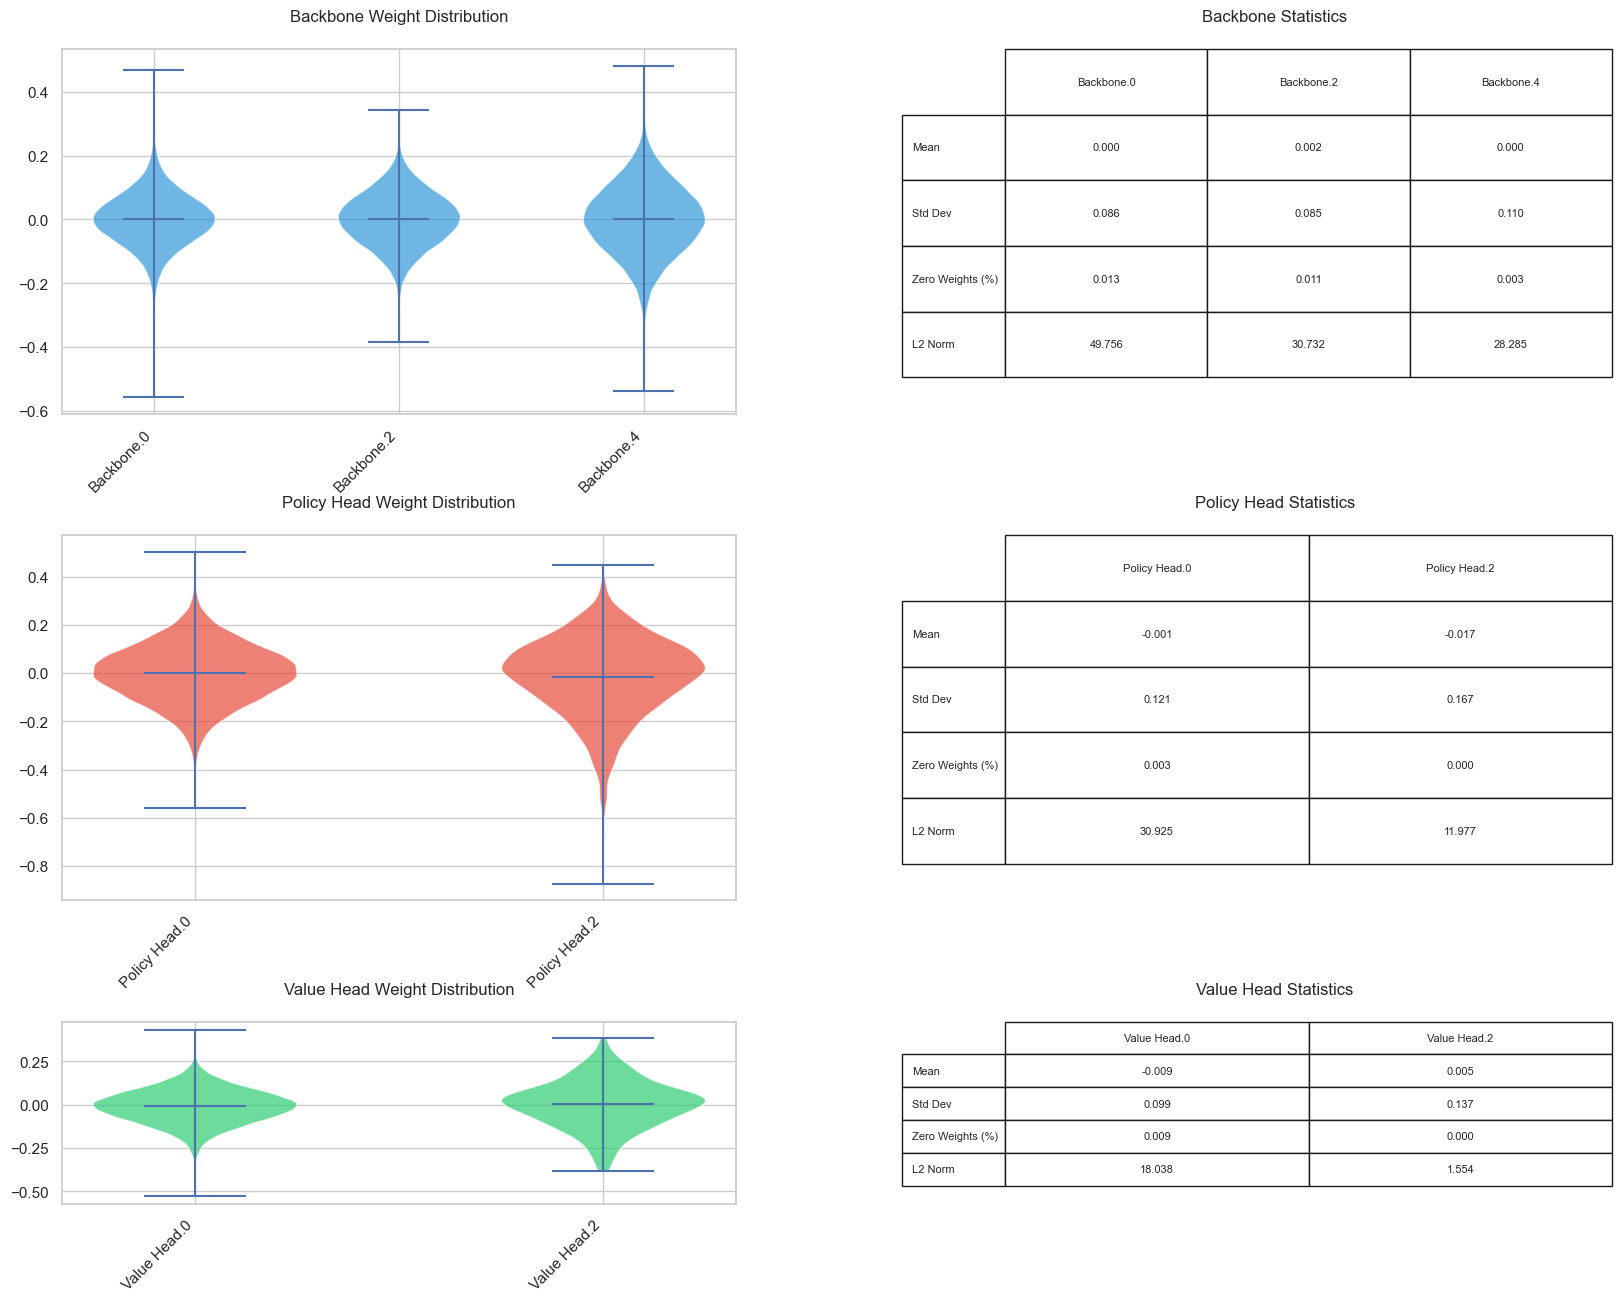


=== Network Analysis ===


In [7]:
# Analyze your model
analyze_network(
    model_path="../saved_models/alphazero_model_100.pth",
    obs_shape=658,
    num_actions=20,
    weight_decay=1e-4,
)

In [5]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def parse_loss_string(loss_str):
    """Extract numerical value from loss string format '0.1234 (56.7%)'"""
    try:
        value = float(loss_str.split(' ')[0])
        return value
    except:
        return np.nan

def create_session_df(scores, policy_losses, value_losses, session_id, start_episode=0, truncate_to=None):
    """Create DataFrame for a training session with computed metrics"""
    # Ensure all arrays are the same length by taking the minimum length
    min_length = min(len(scores), len(policy_losses), len(value_losses))
    if truncate_to is not None:
        min_length = min(min_length, truncate_to)
    
    # Truncate all arrays to the same length
    scores = scores[:min_length]
    policy_losses = policy_losses[:min_length]
    value_losses = value_losses[:min_length]
    
    # Parse loss values
    policy_values = [parse_loss_string(x) for x in policy_losses]
    value_values = [parse_loss_string(x) for x in value_losses]
    total_loss = [p + v for p, v in zip(policy_values, value_values)]
    
    # Create episode numbers
    episode_numbers = range(start_episode, start_episode + min_length)
    
    # Create DataFrame with all metrics
    df = pd.DataFrame({
        'Episode': episode_numbers,
        'Score': scores,
        'Policy Loss': policy_values,
        'Value Loss': value_values,
        'Total Loss': total_loss,
        'Session': f'Session {session_id}'
    })
    
    # Add moving averages after DataFrame creation
    df['Moving Avg Score'] = df['Score'].rolling(window=50, min_periods=1).mean()
    df['Moving Std Score'] = df['Score'].rolling(window=50, min_periods=1).std()
    
    return df

def plot_training_progress_interactive(all_sessions_df, use_log_scale=True):
    """Create interactive visualization of training progress using plotly"""
    
    # Create figure with secondary y-axes
    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=('Game Scores', 'Total Loss', 'Loss Components'),
        row_heights=[0.5, 0.25, 0.25],
        vertical_spacing=0.1
    )

    # Color scheme
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']
    
    # First subplot: Scores
    for idx, session in enumerate(sorted(all_sessions_df['Session'].unique())):
        session_data = all_sessions_df[all_sessions_df['Session'] == session]
        color = colors[idx % len(colors)]
        
        # Raw scores as scatter
        fig.add_trace(
            go.Scatter(
                x=session_data['Episode'],
                y=session_data['Score'],
                mode='markers',
                name=f'{session} (Raw)',
                marker=dict(size=3, color=color, opacity=0.3),
                showlegend=False,
                hovertemplate="Episode: %{x}<br>Score: %{y}<extra></extra>"
            ),
            row=1, col=1
        )
        
        # Moving average
        fig.add_trace(
            go.Scatter(
                x=session_data['Episode'],
                y=session_data['Moving Avg Score'],
                mode='lines',
                name=f'{session}',
                line=dict(color=color, width=2),
                hovertemplate="Episode: %{x}<br>Moving Avg Score: %{y:.2f}<extra></extra>"
            ),
            row=1, col=1
        )
        
        # Confidence interval
        fig.add_trace(
            go.Scatter(
                x=session_data['Episode'].tolist() + session_data['Episode'].tolist()[::-1],
                y=(session_data['Moving Avg Score'] + session_data['Moving Std Score']).tolist() + 
                  (session_data['Moving Avg Score'] - session_data['Moving Std Score']).tolist()[::-1],
                fill='toself',
                fillcolor=f'rgba{tuple(list(int(color.lstrip("#")[i:i+2], 16) for i in (0, 2, 4)) + [0.2])}',
                line=dict(color='rgba(255,255,255,0)'),
                showlegend=False,
                hoverinfo='skip'
            ),
            row=1, col=1
        )
    
    # Second subplot: Total Loss
    for idx, session in enumerate(sorted(all_sessions_df['Session'].unique())):
        session_data = all_sessions_df[all_sessions_df['Session'] == session]
        fig.add_trace(
            go.Scatter(
                x=session_data['Episode'],
                y=session_data['Total Loss'],
                mode='lines',
                line=dict(color=colors[idx % len(colors)]),
                showlegend=False,
                hovertemplate="Episode: %{x}<br>Total Loss: %{y:.4f}<extra></extra>"
            ),
            row=2, col=1
        )
    
    # Third subplot: Loss Components
    fig.add_trace(
        go.Scatter(
            x=all_sessions_df['Episode'],
            y=all_sessions_df['Policy Loss'],
            mode='lines',
            name='Policy Loss',
            line=dict(color='#17BECF'),
            hovertemplate="Episode: %{x}<br>Policy Loss: %{y:.4f}<extra></extra>"
        ),
        row=3, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=all_sessions_df['Episode'],
            y=all_sessions_df['Value Loss'],
            mode='lines',
            name='Value Loss',
            line=dict(color='#7F7F7F'),
            hovertemplate="Episode: %{x}<br>Value Loss: %{y:.4f}<extra></extra>"
        ),
        row=3, col=1
    )
    
    # Update layout
    fig.update_layout(
        height=900,
        title_text="AlphaZero Training Progress",
        showlegend=True,
        hovermode='x unified',
        template='plotly_white'
    )
    
    # Update axes
    if use_log_scale:
        fig.update_yaxes(type="log", row=2, col=1)
        fig.update_yaxes(type="log", row=3, col=1)
    
    # Update y-axis labels
    fig.update_yaxes(title_text="Score", row=1, col=1)
    fig.update_yaxes(title_text="Total Loss", row=2, col=1)
    fig.update_yaxes(title_text="Loss Value", row=3, col=1)
    
    # Update x-axis labels
    fig.update_xaxes(title_text="Episode", row=3, col=1)
    
    return fig


# Your data goes here
sessions_data = {
    1: {
        'scores': [15, 9, 13, 11, 11, 15, 7, 8, 12, 11, 11, 12, 11, 6, 10, 11, 4, 10, 8, 10, 13, 8, 11, 8, 7, 13, 12, 9, 12, 9, 7, 13, 8, 12, 9, 12, 11, 7, 6, 4, 8, 5, 10, 12, 6, 10, 12, 12, 6, 5, 13, 10, 10, 8, 10, 7, 6, 7, 14, 8, 8, 11, 10, 11, 7, 7, 10, 10, 9, 5, 5, 7, 7, 3, 8, 7, 11, 6, 8, 3, 8, 8, 11, 8, 10, 8, 4, 13, 7, 8, 9, 8, 5, 5, 10, 12, 8, 8, 7, 10],
        'policy_losses': ['3.1150 (47.2%)', '3.0675 (70.4%)', '2.9714 (84.8%)', '2.9188 (85.0%)', '2.9276 (83.4%)', '2.8744 (77.3%)', '2.7901 (79.6%)', '2.8087 (82.3%)', '2.7881 (81.0%)', '2.7677 (80.9%)', '2.7210 (81.4%)', '2.6977 (85.6%)', '2.5620 (83.5%)', '2.6071 (87.4%)', '2.4970 (88.8%)', '2.6050 (87.3%)', '2.5391 (89.7%)', '2.5414 (91.2%)', '2.6017 (90.4%)', '2.4482 (91.0%)', '2.5227 (89.6%)', '2.4865 (86.7%)', '2.4672 (90.7%)', '2.4268 (89.3%)', '2.5199 (89.6%)', '2.4328 (90.0%)', '2.4741 (93.0%)', '2.4534 (93.9%)', '2.4261 (90.6%)', '2.4583 (93.4%)', '2.4659 (92.1%)', '2.4364 (92.7%)', '2.4903 (92.1%)', '2.3886 (93.4%)', '2.4674 (90.3%)', '2.4016 (93.6%)', '2.4317 (91.3%)', '2.4490 (92.3%)', '2.3760 (93.9%)', '2.3939 (92.2%)', '2.3748 (92.6%)', '2.3744 (92.8%)', '2.3744 (92.6%)', '2.3912 (94.1%)', '2.3570 (93.3%)', '2.3804 (93.0%)', '2.4071 (95.0%)', '2.3579 (94.6%)', '2.4198 (93.5%)', '2.3740 (94.0%)', '2.3982 (93.6%)', '2.3494 (94.9%)', '2.3338 (93.0%)', '2.4133 (94.1%)', '2.3993 (94.3%)', '2.3621 (95.3%)', '2.3933 (94.9%)', '2.3804 (94.3%)', '2.3194 (93.7%)', '2.3848 (95.1%)', '2.3313 (94.9%)', '2.4288 (94.9%)', '2.3264 (95.2%)', '2.4265 (95.0%)', '2.3754 (96.0%)', '2.2927 (96.0%)', '2.3597 (95.6%)', '2.3070 (94.3%)', '2.3690 (95.7%)', '2.3707 (96.5%)', '2.3462 (96.9%)', '2.2927 (95.4%)', '2.3278 (95.6%)', '2.3079 (96.2%)', '2.2827 (95.0%)', '2.3928 (96.1%)', '2.3156 (95.4%)', '2.3225 (94.8%)', '2.3622 (95.6%)', '2.3120 (95.1%)', '2.3065 (94.3%)', '2.3327 (96.5%)', '2.3330 (96.4%)', '2.3201 (96.3%)', '2.3133 (96.4%)', '2.3189 (97.2%)', '2.3032 (96.2%)', '2.3276 (95.3%)', '2.3094 (95.6%)', '2.3195 (95.9%)', '2.3043 (97.2%)', '2.3241 (96.6%)', '2.2800 (96.3%)', '2.2832 (96.8%)', '2.3728 (95.7%)', '2.2199 (96.8%)', '2.3023 (96.4%)', '2.5645 (96.5%)', '2.3514 (96.4%)', '2.3541 (97.9%)'],
        'value_losses': ['0.3490 (52.8%)', '0.1293 (29.6%)', '0.0531 (15.2%)', '0.0514 (15.0%)', '0.0584 (16.6%)', '0.0845 (22.7%)', '0.0715 (20.4%)', '0.0605 (17.7%)', '0.0656 (19.0%)', '0.0652 (19.1%)', '0.0623 (18.6%)', '0.0455 (14.4%)', '0.0505 (16.5%)', '0.0377 (12.6%)', '0.0316 (11.2%)', '0.0378 (12.7%)', '0.0291 (10.3%)', '0.0245 (8.8%)', '0.0275 (9.6%)', '0.0241 (9.0%)', '0.0294 (10.4%)', '0.0382 (13.3%)', '0.0253 (9.3%)', '0.0291 (10.7%)', '0.0291 (10.4%)', '0.0271 (10.0%)', '0.0186 (7.0%)', '0.0161 (6.1%)', '0.0253 (9.4%)', '0.0173 (6.6%)', '0.0211 (7.9%)', '0.0193 (7.3%)', '0.0212 (7.9%)', '0.0170 (6.6%)', '0.0264 (9.7%)', '0.0165 (6.4%)', '0.0233 (8.7%)', '0.0206 (7.7%)', '0.0154 (6.1%)', '0.0202 (7.8%)', '0.0190 (7.4%)', '0.0185 (7.2%)', '0.0189 (7.4%)', '0.0149 (5.9%)', '0.0168 (6.7%)', '0.0180 (7.0%)', '0.0127 (5.0%)', '0.0134 (5.4%)', '0.0168 (6.5%)', '0.0151 (6.0%)', '0.0165 (6.4%)', '0.0127 (5.1%)', '0.0177 (7.0%)', '0.0150 (5.9%)', '0.0146 (5.7%)', '0.0116 (4.7%)', '0.0128 (5.1%)', '0.0143 (5.7%)', '0.0157 (6.3%)', '0.0123 (4.9%)', '0.0124 (5.1%)', '0.0131 (5.1%)', '0.0118 (4.8%)', '0.0128 (5.0%)', '0.0099 (4.0%)', '0.0096 (4.0%)', '0.0108 (4.4%)', '0.0139 (5.7%)', '0.0107 (4.3%)', '0.0085 (3.5%)', '0.0076 (3.1%)', '0.0111 (4.6%)', '0.0108 (4.4%)', '0.0092 (3.8%)', '0.0121 (5.0%)', '0.0096 (3.9%)', '0.0112 (4.6%)', '0.0127 (5.2%)', '0.0110 (4.4%)', '0.0118 (4.9%)', '0.0140 (5.7%)', '0.0086 (3.5%)', '0.0087 (3.6%)', '0.0090 (3.7%)', '0.0087 (3.6%)', '0.0066 (2.8%)', '0.0091 (3.8%)', '0.0115 (4.7%)', '0.0105 (4.4%)', '0.0100 (4.1%)', '0.0066 (2.8%)', '0.0081 (3.4%)', '0.0088 (3.7%)', '0.0075 (3.2%)', '0.0106 (4.3%)', '0.0073 (3.2%)', '0.0086 (3.6%)', '0.0093 (3.5%)', '0.0087 (3.6%)', '0.0050 (2.1%)'],
        'start_episode': 0,
        'truncate_to': 100
    },
    2: {
        'scores': [11, 8, 8, 9, 12, 13, 12, 14, 15, 8, 13, 11, 11, 9, 10, 10, 18, 11, 7, 9, 10, 15, 8, 12, 10, 10, 12, 5, 11, 9, 14, 10, 9, 6, 11, 12, 15, 4, 11, 6, 9, 11, 11, 13, 10, 12, 11, 11, 14, 10, 11, 11, 13, 12, 9, 11, 8, 8, 14, 12, 11, 8, 11, 7, 19, 12, 10, 15, 11, 11, 11, 15, 7, 13, 15, 9, 6, 12, 9, 11, 7, 12, 13, 3, 15, 14, 13, 12, 8, 10, 8, 15, 12, 13, 8, 9, 11, 12, 12, 12],
        'policy_losses': ['3.0705 (36.7%)', '2.9089 (48.5%)', '2.8765 (64.9%)', '2.8067 (77.6%)', '2.8414 (79.9%)', '2.7499 (78.6%)', '2.7678 (78.6%)', '2.7265 (79.1%)', '2.6773 (72.6%)', '2.5901 (74.8%)', '2.5989 (73.7%)', '2.5580 (74.2%)', '2.6044 (75.3%)', '2.5621 (74.4%)', '2.4985 (72.3%)', '2.5461 (75.4%)', '2.5275 (73.7%)', '2.4548 (77.6%)', '2.5019 (79.0%)', '2.4754 (81.6%)', '2.5118 (83.0%)', '2.4693 (80.0%)', '2.4550 (82.9%)', '2.4769 (87.7%)', '2.5198 (88.5%)', '2.4503 (87.2%)', '2.4640 (89.7%)', '2.4456 (90.0%)', '2.5334 (89.4%)', '2.4642 (90.3%)', '2.4186 (87.9%)', '2.4175 (87.9%)', '2.4246 (89.0%)', '2.4363 (86.8%)', '2.4113 (90.2%)', '2.4662 (89.4%)', '2.4420 (90.7%)', '2.4748 (92.0%)', '2.3997 (90.0%)', '2.4209 (93.3%)', '2.3884 (93.8%)', '2.3996 (91.0%)', '2.3709 (93.1%)', '2.4185 (91.3%)', '2.4444 (91.7%)', '2.4372 (89.7%)', '2.4544 (93.4%)', '2.3961 (92.4%)', '2.3787 (92.6%)', '2.3950 (91.9%)', '2.3806 (91.9%)', '2.4167 (92.5%)', '2.3995 (93.7%)', '2.4051 (93.7%)', '2.4079 (94.0%)', '2.4095 (92.9%)', '2.3514 (94.6%)', '2.3795 (92.5%)', '2.3682 (94.2%)', '2.3933 (93.7%)', '2.3978 (92.1%)', '2.3879 (92.8%)', '2.3688 (93.3%)', '2.3597 (93.3%)', '2.3901 (93.3%)', '2.3441 (94.2%)', '2.3765 (93.5%)', '2.3670 (94.6%)', '2.3754 (94.7%)', '2.3319 (95.1%)', '2.3657 (93.7%)', '2.3461 (94.4%)', '2.3948 (95.7%)', '2.6993 (95.2%)', '2.3542 (93.7%)', '2.3541 (93.7%)', '2.3682 (94.6%)', '2.3205 (94.3%)', '2.3573 (94.1%)', '2.3717 (95.2%)', '2.3566 (95.3%)', '2.3664 (95.8%)', '2.3159 (96.0%)', '2.3698 (94.0%)', '2.3170 (94.2%)', '2.3660 (94.6%)', '2.6495 (95.6%)', '2.3343 (95.6%)', '2.3323 (95.0%)', '2.3864 (95.6%)', '2.6380 (95.9%)', '2.6384 (95.7%)', '2.3674 (95.5%)', '2.3571 (95.7%)', '2.3250 (95.3%)', '2.3476 (96.4%)', '2.3636 (95.5%)', '2.6416 (95.8%)', '2.3354 (96.8%)', '2.3159 (96.9%)'],
        'value_losses': ['0.5293 (63.3%)', '0.3091 (51.5%)', '0.1554 (35.1%)', '0.0812 (22.4%)', '0.0717 (20.1%)', '0.0749 (21.4%)', '0.0753 (21.4%)', '0.0718 (20.9%)', '0.1009 (27.4%)', '0.0872 (25.2%)', '0.0928 (26.3%)', '0.0890 (25.8%)', '0.0854 (24.7%)', '0.0879 (25.6%)', '0.0959 (27.7%)', '0.0830 (24.6%)', '0.0901 (26.3%)', '0.0709 (22.4%)', '0.0665 (21.0%)', '0.0560 (18.4%)', '0.0513 (17.0%)', '0.0618 (20.0%)', '0.0508 (17.1%)', '0.0348 (12.3%)', '0.0327 (11.5%)', '0.0359 (12.8%)', '0.0283 (10.3%)', '0.0273 (10.0%)', '0.0299 (10.6%)', '0.0265 (9.7%)', '0.0333 (12.1%)', '0.0334 (12.1%)', '0.0299 (11.0%)', '0.0371 (13.2%)', '0.0262 (9.8%)', '0.0293 (10.6%)', '0.0251 (9.3%)', '0.0217 (8.0%)', '0.0265 (10.0%)', '0.0175 (6.7%)', '0.0157 (6.2%)', '0.0237 (9.0%)', '0.0175 (6.9%)', '0.0229 (8.7%)', '0.0221 (8.3%)', '0.0279 (10.3%)', '0.0173 (6.6%)', '0.0198 (7.6%)', '0.0189 (7.4%)', '0.0211 (8.1%)', '0.0210 (8.1%)', '0.0197 (7.5%)', '0.0161 (6.3%)', '0.0161 (6.3%)', '0.0154 (6.0%)', '0.0185 (7.1%)', '0.0133 (5.4%)', '0.0193 (7.5%)', '0.0147 (5.8%)', '0.0160 (6.3%)', '0.0205 (7.9%)', '0.0185 (7.2%)', '0.0170 (6.7%)', '0.0168 (6.7%)', '0.0173 (6.7%)', '0.0145 (5.8%)', '0.0165 (6.5%)', '0.0135 (5.4%)', '0.0133 (5.3%)', '0.0119 (4.9%)', '0.0159 (6.3%)', '0.0139 (5.6%)', '0.0106 (4.3%)', '0.0135 (4.8%)', '0.0160 (6.3%)', '0.0158 (6.3%)', '0.0136 (5.4%)', '0.0141 (5.7%)', '0.0149 (5.9%)', '0.0120 (4.8%)', '0.0115 (4.7%)', '0.0105 (4.2%)', '0.0097 (4.0%)', '0.0152 (6.0%)', '0.0143 (5.8%)', '0.0136 (5.4%)', '0.0122 (4.4%)', '0.0107 (4.4%)', '0.0123 (5.0%)', '0.0109 (4.4%)', '0.0113 (4.1%)', '0.0118 (4.3%)', '0.0111 (4.5%)', '0.0105 (4.3%)', '0.0113 (4.7%)', '0.0088 (3.6%)', '0.0111 (4.5%)', '0.0117 (4.2%)', '0.0077 (3.2%)', '0.0074 (3.1%)'],
        'start_episode': 100,
        'truncate_to': 100
    },
    3: {
        'scores': [15, 10, 14, 9, 10, 7, 14, 9, 10, 10, 11, 13, 11, 11, 8, 15, 6, 7, 13, 14, 12, 15, 11, 11, 12, 8, 12, 6, 12, 12, 7, 4, 16, 9, 11, 14, 9, 11, 14, 11, 12, 9, 16, 12, 11, 12, 10, 11, 13, 12, 12, 12, 8, 10, 13, 11, 11, 10, 13, 14, 12, 13, 6, 6, 16, 13, 12, 12, 4, 10, 10, 6, 6, 12, 8, 12, 7, 8, 12, 8, 11, 11, 13, 9, 12, 14, 16, 12, 13, 12, 10, 7, 15, 14, 12, 12, 10, 15, 14, 10],
        'policy_losses': ['2.8670 (96.8%)', '2.7469 (95.5%)', '2.7738 (96.0%)', '2.7098 (95.2%)', '2.7278 (95.9%)', '2.6218 (95.6%)', '2.6416 (95.1%)', '2.5385 (95.0%)', '2.5505 (96.4%)', '2.5312 (96.5%)', '2.5873 (95.6%)', '2.5087 (96.4%)', '2.5240 (97.2%)', '2.4933 (97.0%)', '2.4255 (96.6%)', '2.5487 (96.6%)', '2.4674 (96.4%)', '2.4460 (96.9%)', '2.4002 (97.0%)', '2.3931 (97.3%)', '2.3973 (97.3%)', '2.4225 (97.1%)', '2.4504 (97.7%)', '2.4205 (97.7%)', '2.3358 (97.4%)', '2.3764 (97.1%)', '2.3912 (97.3%)', '2.4177 (97.3%)', '2.3648 (97.6%)', '2.3412 (98.1%)', '2.3839 (97.4%)', '2.3645 (97.5%)', '2.3695 (97.8%)', '2.3625 (97.7%)', '2.3025 (98.0%)', '2.3979 (98.2%)', '2.3532 (97.7%)', '2.3116 (98.1%)', '2.3632 (97.7%)', '2.3770 (98.0%)', '2.3723 (97.5%)', '2.3329 (98.0%)', '2.2906 (97.9%)', '2.2981 (97.9%)', '2.2973 (97.4%)', '2.2587 (97.6%)', '2.3193 (98.5%)', '2.2782 (97.8%)', '2.2472 (97.4%)', '2.3151 (98.2%)', '2.3092 (98.3%)', '2.3514 (98.0%)', '2.3329 (98.3%)', '2.1875 (98.0%)', '2.2107 (98.8%)', '2.3323 (98.5%)', '2.2664 (98.1%)', '2.2940 (98.5%)', '2.2727 (98.4%)', '2.3009 (98.1%)', '2.2588 (98.1%)', '2.2705 (98.3%)', '2.2779 (98.5%)', '2.2419 (98.1%)', '2.2726 (98.4%)', '2.1994 (98.3%)', '2.2702 (98.4%)', '2.2290 (98.5%)', '2.3034 (98.4%)', '2.2365 (98.5%)', '2.2593 (98.3%)', '2.2458 (98.4%)', '2.2084 (97.7%)', '2.1735 (98.5%)', '2.2856 (98.1%)', '2.1839 (98.5%)', '2.2002 (98.9%)', '2.2231 (98.7%)', '2.2570 (97.9%)', '2.2375 (98.4%)', '2.1868 (98.7%)', '2.2422 (99.0%)', '2.1706 (98.6%)', '2.2127 (98.1%)', '2.1511 (97.9%)', '2.1618 (98.7%)', '2.2145 (98.1%)', '2.1852 (98.6%)', '2.1965 (98.5%)', '2.2527 (99.0%)', '2.4357 (99.0%)', '2.1708 (98.6%)', '2.1807 (98.7%)', '2.1259 (98.0%)', '2.1536 (98.4%)', '2.1617 (99.1%)', '2.1136 (98.3%)', '2.1468 (99.0%)', '2.1239 (98.0%)', '2.0728 (99.1%)'],
        'value_losses': ['0.0093 (3.2%)', '0.0131 (4.5%)', '0.0116 (4.0%)', '0.0137 (4.8%)', '0.0118 (4.1%)', '0.0121 (4.4%)', '0.0137 (4.9%)', '0.0132 (5.0%)', '0.0096 (3.6%)', '0.0093 (3.5%)', '0.0120 (4.4%)', '0.0093 (3.6%)', '0.0073 (2.8%)', '0.0076 (3.0%)', '0.0085 (3.4%)', '0.0090 (3.4%)', '0.0093 (3.6%)', '0.0079 (3.1%)', '0.0074 (3.0%)', '0.0065 (2.7%)', '0.0067 (2.7%)', '0.0072 (2.9%)', '0.0059 (2.3%)', '0.0057 (2.3%)', '0.0062 (2.6%)', '0.0071 (2.9%)', '0.0068 (2.7%)', '0.0067 (2.7%)', '0.0058 (2.4%)', '0.0046 (1.9%)', '0.0063 (2.6%)', '0.0060 (2.5%)', '0.0054 (2.2%)', '0.0055 (2.3%)', '0.0047 (2.0%)', '0.0043 (1.8%)', '0.0054 (2.3%)', '0.0045 (1.9%)', '0.0056 (2.3%)', '0.0047 (2.0%)', '0.0062 (2.5%)', '0.0046 (2.0%)', '0.0050 (2.1%)', '0.0049 (2.1%)', '0.0061 (2.6%)', '0.0054 (2.4%)', '0.0036 (1.5%)', '0.0052 (2.2%)', '0.0060 (2.6%)', '0.0042 (1.8%)', '0.0041 (1.7%)', '0.0047 (2.0%)', '0.0040 (1.7%)', '0.0044 (2.0%)', '0.0027 (1.2%)', '0.0037 (1.5%)', '0.0044 (1.9%)', '0.0035 (1.5%)', '0.0037 (1.6%)', '0.0045 (1.9%)', '0.0045 (1.9%)', '0.0039 (1.7%)', '0.0035 (1.5%)', '0.0042 (1.9%)', '0.0037 (1.6%)', '0.0038 (1.7%)', '0.0037 (1.6%)', '0.0035 (1.5%)', '0.0037 (1.6%)', '0.0033 (1.5%)', '0.0038 (1.7%)', '0.0037 (1.6%)', '0.0051 (2.3%)', '0.0033 (1.5%)', '0.0045 (1.9%)', '0.0033 (1.5%)', '0.0023 (1.1%)', '0.0028 (1.3%)', '0.0047 (2.1%)', '0.0037 (1.6%)', '0.0029 (1.3%)', '0.0023 (1.0%)', '0.0031 (1.4%)', '0.0043 (1.9%)', '0.0046 (2.1%)', '0.0029 (1.3%)', '0.0042 (1.9%)', '0.0031 (1.4%)', '0.0033 (1.5%)', '0.0023 (1.0%)', '0.0025 (1.0%)', '0.0030 (1.4%)', '0.0029 (1.3%)', '0.0043 (2.0%)', '0.0034 (1.6%)', '0.0019 (0.9%)', '0.0036 (1.7%)', '0.0021 (1.0%)', '0.0042 (2.0%)', '0.0019 (0.9%)'],
        'start_episode': 200,
        'truncate_to': 100
    },
    4: {
        'scores': [10, 9, 16, 6, 5, 12, 10, 10, 8, 12, 9, 13, 5, 7, 9, 10, 12, 9, 8, 12, 12, 10, 10, 13, 12, 10, 9, 12, 16, 9, 6, 13, 9, 12, 13, 9, 12, 15, 7, 14, 15, 9, 11, 9, 11, 11, 14, 11, 9, 8, 12, 11, 14, 12, 6, 7, 7, 7, 13, 12, 13, 14, 15, 12, 10, 13, 10, 11, 12, 9, 13, 10, 12, 13, 14, 14, 12, 14, 13, 12, 12, 8, 11, 13, 7, 11, 7, 10, 9, 15, 15, 11, 10, 9, 15, 12, 16, 11, 15, 13],
        'policy_losses': ['4.4649 (46.7%)', '1.6878 (91.3%)', '1.1717 (60.0%)', '1.0227 (70.0%)', '1.0299 (91.0%)', '0.7243 (94.1%)', '0.8687 (95.1%)', '0.6517 (87.3%)', '0.6177 (89.5%)', '0.4707 (88.0%)', '0.4509 (90.7%)', '0.6290 (85.9%)', '0.3468 (85.5%)', '0.5459 (92.4%)', '0.4560 (87.5%)', '0.5354 (92.8%)', '0.3559 (95.6%)', '0.3410 (94.9%)', '0.4042 (96.9%)', '0.3438 (97.1%)', '0.4668 (92.3%)', '0.4617 (96.0%)', '0.3180 (94.4%)', '0.5185 (92.5%)', '0.3690 (96.3%)', '0.3880 (97.4%)', '0.3892 (96.1%)', '0.3412 (93.7%)', '0.3585 (92.7%)', '0.4112 (92.8%)', '0.4490 (97.7%)', '0.4502 (92.4%)', '0.2972 (94.3%)', '0.3401 (97.2%)', '0.2042 (90.7%)', '0.3552 (95.7%)', '0.3874 (88.9%)', '0.3389 (93.9%)', '0.2842 (87.7%)', '0.2315 (89.3%)', '0.2802 (91.7%)', '0.2810 (93.7%)', '0.3686 (96.6%)', '0.4608 (94.0%)', '0.3202 (95.5%)', '0.3571 (95.8%)', '0.3390 (95.2%)', '0.2729 (96.5%)', '0.2648 (96.1%)', '0.2689 (94.7%)', '0.1639 (97.6%)', '0.2767 (94.1%)', '0.2884 (95.3%)', '0.2205 (85.1%)', '0.1943 (94.6%)', '0.2602 (93.5%)', '0.3256 (93.6%)', '0.2795 (96.0%)', '0.3160 (90.7%)', '0.2884 (95.4%)', '0.3426 (92.7%)', '0.1951 (95.5%)', '0.2391 (96.2%)', '0.2914 (97.0%)', '0.2316 (98.0%)', '0.2443 (96.5%)', '0.2371 (96.6%)', '0.2875 (94.8%)', '0.1996 (95.6%)', '0.1896 (94.2%)', '0.2966 (96.0%)', '0.1538 (95.0%)', '0.2015 (93.1%)', '0.2189 (95.8%)', '0.2847 (95.0%)', '0.2191 (94.4%)', '0.2775 (96.8%)', '0.2207 (93.5%)', '0.2645 (97.2%)', '0.2082 (95.2%)', '0.2913 (94.2%)', '0.2718 (93.8%)', '0.3503 (96.5%)', '0.2192 (93.7%)', '0.3136 (92.5%)', '0.2000 (96.2%)', '0.2403 (96.7%)', '0.3692 (97.0%)', '0.2985 (95.7%)', '0.3775 (93.7%)', '0.1737 (90.7%)', '0.1846 (96.0%)', '0.1972 (96.5%)', '0.3828 (96.6%)', '0.1731 (97.1%)', '0.0888 (91.1%)', '0.2773 (95.8%)', '0.2231 (94.9%)', '0.2003 (95.6%)'],
        'value_losses': ['0.5103 (53.3%)', '0.0161 (8.7%)', '0.0783 (40.0%)', '0.0437 (30.0%)', '0.0101 (9.0%)', '0.0045 (5.9%)', '0.0045 (4.9%)', '0.0095 (12.7%)', '0.0073 (10.5%)', '0.0064 (12.0%)', '0.0046 (9.3%)', '0.0103 (14.1%)', '0.0059 (14.5%)', '0.0045 (7.6%)', '0.0065 (12.5%)', '0.0042 (7.2%)', '0.0016 (4.4%)', '0.0018 (5.1%)', '0.0013 (3.1%)', '0.0010 (2.9%)', '0.0039 (7.7%)', '0.0019 (4.0%)', '0.0019 (5.6%)', '0.0042 (7.5%)', '0.0014 (3.7%)', '0.0010 (2.6%)', '0.0016 (3.9%)', '0.0023 (6.3%)', '0.0028 (7.3%)', '0.0032 (7.2%)', '0.0010 (2.3%)', '0.0037 (7.6%)', '0.0018 (5.7%)', '0.0010 (2.8%)', '0.0021 (9.3%)', '0.0016 (4.3%)', '0.0048 (11.1%)', '0.0022 (6.1%)', '0.0040 (12.3%)', '0.0028 (10.7%)', '0.0025 (8.3%)', '0.0019 (6.3%)', '0.0013 (3.4%)', '0.0029 (6.0%)', '0.0015 (4.5%)', '0.0016 (4.2%)', '0.0017 (4.8%)', '0.0010 (3.5%)', '0.0011 (3.9%)', '0.0015 (5.3%)', '0.0004 (2.4%)', '0.0017 (5.9%)', '0.0014 (4.7%)', '0.0039 (14.9%)', '0.0011 (5.4%)', '0.0018 (6.5%)', '0.0022 (6.4%)', '0.0012 (4.0%)', '0.0033 (9.3%)', '0.0014 (4.6%)', '0.0027 (7.3%)', '0.0009 (4.5%)', '0.0009 (3.8%)', '0.0009 (3.0%)', '0.0005 (2.0%)', '0.0009 (3.5%)', '0.0008 (3.4%)', '0.0016 (5.2%)', '0.0009 (4.4%)', '0.0012 (5.8%)', '0.0012 (4.0%)', '0.0008 (5.0%)', '0.0015 (6.9%)', '0.0010 (4.2%)', '0.0015 (5.0%)', '0.0013 (5.6%)', '0.0009 (3.2%)', '0.0015 (6.5%)', '0.0008 (2.8%)', '0.0010 (4.8%)', '0.0018 (5.8%)', '0.0018 (6.2%)', '0.0013 (3.5%)', '0.0015 (6.3%)', '0.0026 (7.5%)', '0.0008 (3.8%)', '0.0008 (3.3%)', '0.0011 (3.0%)', '0.0013 (4.3%)', '0.0026 (6.3%)', '0.0018 (9.3%)', '0.0008 (4.0%)', '0.0007 (3.5%)', '0.0013 (3.4%)', '0.0005 (2.9%)', '0.0009 (8.9%)', '0.0012 (4.2%)', '0.0012 (5.1%)', '0.0009 (4.4%)'],
        'start_episode': 300,
        'truncate_to': 100
    },
    5: {
        'scores': [13, 11, 8, 9, 12, 9, 12, 14, 11, 10, 11, 10, 11, 10, 12, 11, 8, 11, 10, 14, 13, 13, 9, 6, 12, 12, 9, 8, 14, 13, 15, 14, 15, 13, 11, 11, 12, 10, 13, 6, 10, 14, 9, 11, 11, 10, 15, 11, 12, 10, 14, 12, 8, 9, 14, 7, 8, 16, 11, 10, 12, 10, 13, 10, 16, 11, 14, 16, 13, 9, 13, 12, 7, 12, 15, 10, 13, 14, 8, 8, 11, 13, 14, 10, 8, 10, 13, 14, 16, 10, 16, 13, 13, 14, 9, 11, 9, 13, 12, 12, 10, 8, 7, 13, 14, 16, 14, 12, 10, 13, 18, 15, 12, 17, 13, 9, 10, 9, 17, 12, 14, 9, 10, 16, 11, 14, 14, 14, 13, 10, 15, 15, 11, 15, 10, 14, 18, 6, 12, 11, 17, 17, 8, 13, 15, 11, 14, 14, 12, 15, 16, 13, 15, 9, 12, 9, 10, 11, 14, 14, 11, 17, 12, 14, 16, 16, 13, 14, 11, 9, 12, 16, 18, 10, 16, 16, 15, 13, 10, 12, 9, 13, 15, 15, 11, 10, 12, 15, 15, 14, 12, 9, 11, 16, 12, 15, 12, 15, 11, 13, 10, 12, 10, 12, 19, 10, 12, 8, 15, 10, 15, 14, 14, 16, 16, 16, 13, 14, 15, 14, 17, 15, 12, 11, 15, 20, 12, 12, 9, 13, 10, 14, 10, 15, 16, 18, 13, 13, 12, 10, 10, 8, 14, 11, 11, 14, 10, 14, 14, 13, 14, 14, 11, 11, 14, 8, 12, 14, 8, 16, 12, 10, 14, 16, 10, 14, 15, 13, 15, 11, 13, 12, 13, 15, 11, 11, 14, 11, 16, 12, 13, 16, 16, 13, 18, 10, 17, 17, 10, 15, 18, 15, 12, 11, 12, 8, 13, 14, 16, 9, 11, 12, 11, 11, 11, 14, 13, 16, 17, 12, 10, 16, 13, 12, 15, 11, 14, 13, 14, 12, 15, 14, 10, 11, 14, 11, 12, 10, 15, 8, 8, 14, 17, 13, 10, 13, 11, 14, 14, 11, 11, 15, 15, 14, 15, 15, 13, 13, 14, 14, 13, 8, 14, 10, 13, 9, 6, 12, 12, 18, 12, 11, 9, 10, 15, 12, 12, 11, 16, 12, 12, 12, 17, 13, 13, 13, 12, 13, 8, 13, 12, 15, 16, 11, 18, 12, 15, 18, 15, 10, 13, 13, 14, 13, 13, 18, 14, 12, 11, 10, 14, 9, 10, 12, 12, 15, 18, 14, 8, 13, 14, 12, 14, 13, 14, 10, 11, 10, 17, 16, 13, 12, 17, 6, 15, 10, 14, 13, 16, 17, 11, 12, 13, 13, 14, 13, 14, 14, 11, 10, 11, 13, 11, 12, 15, 11, 15, 15, 14, 12, 15, 11, 17, 11, 18, 12, 13, 14, 9, 16, 6, 13, 11, 10, 11, 11, 10, 13, 6, 13, 15, 17, 12, 10, 12, 15, 12, 10, 16, 13, 11, 16, 11, 13, 11, 16, 17, 11, 12, 12, 7, 10, 12, 12, 15, 14, 11, 14, 13, 15, 9, 16, 17, 16, 15, 11, 13, 15, 12, 11, 15, 11, 10, 15, 15, 9, 14, 15, 13, 13, 14, 16, 16, 15, 11, 16, 15, 17, 16, 14, 14, 9, 16, 11, 9, 14, 12, 13, 16, 15, 12, 14, 15, 13, 14, 10, 14, 8, 10, 17, 9, 14, 14, 13, 15, 12, 14, 9, 15, 9, 9, 11, 17, 12, 9, 14, 10, 13, 13, 9, 16, 17, 16, 7, 15, 15, 15, 13, 13, 16, 19, 14, 10, 12, 11, 16, 17, 15, 16, 10, 16, 15, 15, 15, 10, 15, 14, 14, 12, 13, 15, 11, 15, 11, 15, 17, 13, 10, 8, 11, 18, 15, 12, 16, 14, 14, 12, 16, 12, 5, 13, 15, 17, 14, 14, 18, 12, 12, 12, 16, 13, 11, 15, 17, 13, 15, 15, 16, 14, 11, 12, 14, 17, 13, 14, 13, 17, 18, 13, 14, 10, 13, 17, 14, 9, 14, 14, 17, 13, 12, 13, 10, 15, 15, 13, 16, 12, 10, 13, 12, 14, 15, 11, 15, 16, 14, 12, 13, 12, 16, 13, 18, 14, 14, 17, 12, 9, 12, 11, 15, 6, 17, 9, 13, 14, 12, 11, 12, 15, 11, 19, 10, 13, 15, 15, 12, 17, 19, 16, 17, 13, 14, 10, 14, 13, 12, 11, 7, 11, 9, 12, 12, 13, 13, 12, 13, 13, 14, 13, 15, 15, 12, 12, 15, 14, 13, 13, 17, 16, 14, 12, 15, 13, 12, 12, 12, 11, 12, 14, 12, 8, 13, 15, 12, 15, 11, 17, 15, 13, 16, 12, 15, 12, 14, 14, 12, 11, 15, 13, 8, 14, 8, 13, 13, 13, 11, 16, 14, 10, 12, 16, 13, 16, 13, 15, 10, 10, 14, 16, 17, 16, 13, 14, 15, 13, 9, 18, 9, 15, 12, 14, 12, 11, 10, 15, 14, 15, 15, 9, 13, 9, 13, 14, 15, 9, 16, 15, 16, 12, 14, 14, 10, 13, 15, 16, 11, 10, 11, 16, 18, 17, 16, 19, 12, 10, 13, 15, 11, 18, 15, 14, 15, 15, 13, 11, 9, 14, 12, 11, 18, 17, 14, 15, 13, 13, 13, 10, 10, 14, 17, 9, 11, 18, 14, 14, 18, 16, 10, 17, 8, 17, 18, 17, 16, 16, 15, 13, 13, 14, 12, 15, 12, 17, 12, 15, 14, 19, 14, 11, 13, 17, 10, 18, 15, 15, 14, 8, 9, 9, 16, 13, 14, 14, 13, 9, 14, 16, 16, 13, 17, 18, 10, 13, 15, 13, 15, 17, 13, 15, 13, 14, 16, 17, 14, 11, 13, 17, 14, 9, 13, 13, 14, 18, 13, 14, 13, 11, 16, 14, 9, 13, 15, 12, 13, 16, 14, 14, 14, 14, 9, 15, 12, 17, 14, 12, 16, 13, 10, 14, 14, 11, 12, 16, 11, 15, 18, 16, 15, 17, 20, 13, 15, 17, 17, 13, 15, 13, 17, 15, 12, 14, 15, 8, 12, 10, 16, 10, 12, 14, 14, 14, 13, 13, 16, 15, 11, 13, 15, 11, 15],
        'policy_losses': ['4.1798 (93.9%)', '1.3658 (79.8%)', '1.0123 (91.2%)', '0.9713 (93.1%)', '0.7240 (94.0%)', '0.6444 (95.9%)', '0.7263 (92.5%)', '0.5274 (96.4%)', '0.5977 (97.2%)', '0.4246 (97.7%)', '0.5471 (96.3%)', '0.5213 (98.7%)', '0.5512 (96.9%)', '0.6227 (98.3%)', '0.4424 (98.3%)', '0.5011 (96.0%)', '0.4372 (97.9%)', '0.5744 (98.2%)', '0.4449 (97.3%)', '0.4044 (94.5%)', '0.5083 (93.8%)', '0.4045 (96.4%)', '0.3958 (89.2%)', '0.4205 (96.3%)', '0.3792 (97.0%)', '0.3619 (97.7%)', '0.2372 (96.0%)', '0.4437 (94.4%)', '0.4183 (98.2%)', '0.2814 (92.1%)', '0.3417 (91.9%)', '0.3644 (92.9%)', '0.3404 (96.8%)', '0.3008 (97.8%)', '0.3565 (98.0%)', '0.3790 (98.5%)', '0.2913 (97.7%)', '0.3546 (97.5%)', '0.4139 (93.7%)', '0.3585 (96.7%)', '0.3180 (95.8%)', '0.3159 (96.8%)', '0.3698 (98.1%)', '0.3013 (98.3%)', '0.3073 (98.3%)', '0.1798 (96.3%)', '0.3396 (97.2%)', '0.2218 (98.0%)', '0.2258 (97.9%)', '0.2568 (97.5%)', '0.2950 (96.2%)', '0.3105 (96.5%)', '0.2018 (96.9%)', '0.3125 (96.9%)', '0.1591 (92.4%)', '0.2867 (93.4%)', '0.3707 (95.0%)', '0.2888 (94.8%)', '0.2452 (97.5%)', '0.2339 (97.4%)', '0.2816 (98.1%)', '0.1382 (97.3%)', '0.2179 (97.9%)', '0.2600 (95.9%)', '0.2035 (97.0%)', '0.2066 (94.2%)', '0.3092 (95.2%)', '0.2120 (97.1%)', '0.2459 (96.7%)', '0.3152 (97.6%)', '0.2929 (96.5%)', '0.3171 (93.7%)', '0.2189 (96.9%)', '0.2058 (94.7%)', '0.2364 (96.3%)', '0.2082 (97.1%)', '0.2152 (95.7%)', '0.2693 (96.0%)', '0.1129 (92.3%)', '0.2436 (97.1%)', '0.1853 (96.8%)', '0.2371 (97.2%)', '0.2226 (97.2%)', '0.2169 (93.9%)', '0.1470 (97.8%)', '0.3368 (96.7%)', '0.1878 (95.0%)', '0.2931 (95.3%)', '0.2073 (96.9%)', '0.1913 (95.8%)', '0.2248 (95.1%)', '0.1545 (94.6%)', '0.1614 (97.1%)', '0.2189 (95.5%)', '0.1421 (96.5%)', '0.2787 (96.6%)', '0.2221 (97.4%)', '0.2091 (97.4%)', '0.2629 (97.2%)', '0.2275 (97.2%)', '0.2102 (97.8%)', '0.2419 (96.2%)', '0.2964 (96.9%)', '0.2348 (97.2%)', '0.2145 (96.2%)', '0.4325 (96.4%)', '0.1312 (92.8%)', '0.2803 (98.0%)', '0.2467 (96.0%)', '0.2074 (96.2%)', '0.2689 (96.7%)', '0.1752 (93.6%)', '0.2517 (96.4%)', '0.1584 (93.5%)', '0.2304 (95.0%)', '0.2095 (95.7%)', '0.2140 (96.2%)', '0.1359 (94.4%)', '0.0766 (92.7%)', '0.2172 (97.1%)', '0.1648 (95.2%)', '0.2517 (94.7%)', '0.1597 (96.8%)', '0.2469 (94.2%)', '0.2674 (93.4%)', '0.2602 (96.2%)', '0.1939 (95.8%)', '0.3310 (94.0%)', '0.2363 (96.2%)', '0.2003 (96.4%)', '0.1959 (97.6%)', '0.3008 (97.4%)', '0.1918 (96.0%)', '0.2868 (96.6%)', '0.2237 (95.0%)', '0.1858 (94.3%)', '0.2121 (94.7%)', '0.2423 (92.8%)', '0.2238 (95.4%)', '0.2261 (91.7%)', '0.2042 (94.0%)', '0.3786 (95.1%)', '0.2675 (95.5%)', '0.1746 (94.6%)', '0.2518 (97.3%)', '0.2015 (93.3%)', '0.2749 (95.0%)', '0.3013 (94.6%)', '0.1595 (93.2%)', '0.1503 (96.3%)', '0.1785 (96.5%)', '0.1825 (95.2%)', '0.2596 (96.3%)', '0.0854 (93.6%)', '0.1794 (95.0%)', '0.1942 (96.6%)', '0.2951 (96.2%)', '0.2692 (95.6%)', '0.2343 (95.4%)', '0.3018 (95.0%)', '0.1413 (95.2%)', '0.1683 (94.0%)', '0.2157 (96.0%)', '0.2834 (94.2%)', '0.2599 (95.0%)', '0.2181 (97.2%)', '0.2887 (95.4%)', '0.2847 (97.1%)', '0.3488 (96.3%)', '0.2007 (96.4%)', '0.2049 (95.6%)', '0.1999 (93.0%)', '0.1404 (95.4%)', '0.2770 (96.0%)', '0.2084 (93.8%)', '0.2383 (91.2%)', '0.1811 (94.8%)', '0.1692 (94.6%)', '0.3465 (94.4%)', '0.1744 (96.2%)', '0.0842 (95.2%)', '0.1801 (96.7%)', '0.1941 (96.2%)', '0.2104 (96.8%)', '0.2346 (97.1%)', '0.2024 (97.4%)', '0.1718 (94.8%)', '0.2823 (96.4%)', '0.1752 (96.1%)', '0.2688 (97.8%)', '0.2682 (96.4%)', '0.3311 (97.2%)', '0.1489 (95.8%)', '0.2684 (96.8%)', '0.2246 (97.2%)', '0.3039 (95.5%)', '0.1674 (95.9%)', '0.2173 (96.5%)', '0.2360 (96.9%)', '0.2980 (96.5%)', '0.2549 (97.0%)', '0.2477 (95.7%)', '0.1873 (96.9%)', '0.1390 (96.7%)', '0.2849 (95.0%)', '0.1259 (96.2%)', '0.2526 (97.3%)', '0.1562 (97.3%)', '0.2332 (96.5%)', '0.3128 (97.0%)', '0.1979 (96.6%)', '0.2554 (96.5%)', '0.2279 (96.7%)', '0.1914 (95.0%)', '0.2473 (96.9%)', '0.1477 (95.0%)', '0.2223 (96.8%)', '0.1933 (96.9%)', '0.2009 (96.8%)', '0.1611 (93.3%)', '0.1977 (96.1%)', '0.3011 (96.8%)', '0.1224 (96.8%)', '0.1701 (96.4%)', '0.1558 (93.7%)', '0.1318 (96.5%)', '0.2653 (93.7%)', '0.2669 (95.9%)', '0.2360 (97.5%)', '0.2654 (96.5%)', '0.2078 (96.3%)', '0.2937 (93.8%)', '0.1560 (96.6%)', '0.0799 (96.8%)', '0.1877 (96.9%)', '0.1031 (95.5%)', '0.1749 (96.8%)', '0.2809 (97.4%)', '0.4059 (96.6%)', '0.2381 (97.6%)', '0.1916 (91.9%)', '0.2500 (95.1%)', '0.2140 (96.3%)', '0.1822 (95.6%)', '0.1326 (97.2%)', '0.1319 (96.4%)', '0.2396 (97.1%)', '0.2755 (96.2%)', '0.2171 (93.4%)', '0.1616 (96.2%)', '0.2617 (96.0%)', '0.2972 (96.8%)', '0.1904 (96.6%)', '0.1257 (97.8%)', '0.1935 (96.6%)', '0.1630 (96.9%)', '0.2282 (97.2%)', '0.2708 (96.5%)', '0.2133 (96.0%)', '0.1595 (96.0%)', '0.1558 (95.0%)', '0.2800 (96.4%)', '0.1936 (95.2%)', '0.1967 (96.0%)', '0.1058 (95.8%)', '0.1769 (97.4%)', '0.2653 (95.9%)', '0.1849 (95.5%)', '0.2606 (97.2%)', '0.2143 (96.6%)', '0.2936 (97.1%)', '0.2329 (95.1%)', '0.1506 (96.4%)', '0.2167 (95.7%)', '0.3019 (97.2%)', '0.1828 (96.0%)', '0.2467 (94.5%)', '0.1954 (97.5%)', '0.2420 (95.5%)', '0.1310 (96.9%)', '0.3033 (97.1%)', '0.1838 (97.1%)', '0.0964 (97.5%)', '0.2474 (96.4%)', '0.3075 (97.9%)', '0.2281 (95.7%)', '0.2950 (96.7%)', '0.2382 (96.8%)', '0.2853 (96.6%)', '0.2354 (97.3%)', '0.1475 (94.5%)', '0.2206 (97.2%)', '0.1797 (97.1%)', '0.2474 (95.5%)', '0.2311 (96.3%)', '0.2723 (97.8%)', '0.2058 (97.7%)', '0.4088 (96.9%)', '0.2222 (96.5%)', '0.3056 (96.7%)', '0.1568 (94.8%)', '0.1435 (97.7%)', '0.2548 (97.5%)', '0.1816 (95.1%)', '0.1874 (96.4%)', '0.1827 (97.2%)', '0.2457 (96.3%)', '0.2782 (96.2%)', '0.3037 (96.5%)', '0.2813 (96.8%)', '0.3047 (97.9%)', '0.2931 (95.5%)', '0.1624 (95.7%)', '0.2131 (95.8%)', '0.2429 (96.9%)', '0.2631 (97.0%)', '0.2956 (97.3%)', '0.2253 (96.2%)', '0.2269 (96.2%)', '0.1809 (97.1%)', '0.2210 (97.5%)', '0.2559 (96.6%)', '0.2269 (95.5%)', '0.2287 (95.7%)', '0.1555 (96.4%)', '0.2599 (96.9%)', '0.2010 (96.7%)', '0.1623 (96.8%)', '0.1721 (97.8%)', '0.2584 (96.1%)', '0.1596 (97.2%)', '0.2293 (95.0%)', '0.1837 (95.9%)', '0.1772 (95.1%)', '0.1926 (96.6%)', '0.1602 (97.0%)', '0.2222 (97.9%)', '0.3091 (96.7%)', '0.2031 (97.7%)', '0.1761 (97.2%)', '0.1819 (97.8%)', '0.1740 (97.2%)', '0.2024 (97.0%)', '0.2396 (96.9%)', '0.2457 (97.6%)', '0.2427 (97.4%)', '0.1785 (97.7%)', '0.2206 (96.7%)', '0.2444 (97.4%)', '0.1539 (94.5%)', '0.3093 (97.0%)', '0.2653 (96.5%)', '0.1865 (96.6%)', '0.2838 (96.6%)', '0.1786 (96.2%)', '0.1660 (93.7%)', '0.2163 (97.3%)', '0.2131 (95.4%)', '0.3217 (92.9%)', '0.2236 (95.8%)', '0.1009 (97.5%)', '0.1031 (96.7%)', '0.1968 (97.6%)', '0.2239 (94.8%)', '0.1129 (96.7%)', '0.1435 (96.4%)', '0.1589 (95.0%)', '0.1423 (96.2%)', '0.1754 (96.0%)', '0.3128 (97.8%)', '0.1881 (97.8%)', '0.2715 (95.7%)', '0.1420 (95.3%)', '0.3416 (96.7%)', '0.2209 (96.3%)', '0.1737 (97.3%)', '0.2043 (96.5%)', '0.2659 (96.8%)', '0.2091 (96.5%)', '0.2115 (95.8%)', '0.2317 (96.6%)', '0.2582 (96.4%)', '0.1672 (95.7%)', '0.2177 (97.3%)', '0.1583 (97.2%)', '0.1667 (96.1%)', '0.1630 (97.1%)', '0.1003 (95.5%)', '0.2025 (95.2%)', '0.2595 (96.8%)', '0.1651 (96.6%)', '0.2254 (96.6%)', '0.1136 (95.9%)', '0.1736 (97.2%)', '0.2399 (95.4%)', '0.2663 (95.2%)', '0.1910 (96.8%)', '0.2761 (97.8%)', '0.1701 (97.8%)', '0.1910 (97.7%)', '0.0928 (96.5%)', '0.1623 (97.1%)', '0.2598 (97.4%)', '0.1946 (95.7%)', '0.1933 (97.3%)', '0.2117 (95.8%)', '0.2267 (96.0%)', '0.2315 (97.3%)', '0.2671 (93.7%)', '0.2026 (94.3%)', '0.1989 (95.7%)', '0.1952 (95.2%)', '0.2950 (97.1%)', '0.1766 (97.1%)', '0.3087 (96.5%)', '0.1721 (96.9%)', '0.1945 (96.1%)', '0.1394 (95.7%)', '0.2350 (97.1%)', '0.1143 (97.8%)', '0.2598 (96.4%)', '0.1295 (96.6%)', '0.2454 (94.3%)', '0.2106 (97.3%)', '0.2226 (95.9%)', '0.2444 (94.4%)', '0.2796 (96.0%)', '0.1579 (96.9%)', '0.0915 (97.0%)', '0.2848 (96.9%)', '0.2670 (96.3%)', '0.2548 (96.0%)', '0.2478 (95.6%)', '0.2770 (96.7%)', '0.1850 (98.0%)', '0.2154 (97.2%)', '0.2533 (97.1%)', '0.1764 (97.8%)', '0.1681 (97.2%)', '0.1575 (97.0%)', '0.2776 (96.9%)', '0.1563 (97.8%)', '0.2340 (98.0%)', '0.1485 (97.0%)', '0.1332 (96.0%)', '0.2011 (96.9%)', '0.1952 (97.0%)', '0.1852 (96.8%)', '0.1462 (97.6%)', '0.2128 (97.4%)', '0.1898 (97.2%)', '0.1644 (95.6%)', '0.1343 (95.9%)', '0.1214 (96.7%)', '0.2481 (96.4%)', '0.1480 (97.8%)', '0.2806 (96.6%)', '0.0752 (94.5%)', '0.1892 (94.1%)', '0.1735 (91.1%)', '0.1958 (95.5%)', '0.2524 (95.8%)', '0.1715 (94.3%)', '0.1837 (96.6%)', '0.2754 (96.3%)', '0.1148 (94.1%)', '0.2483 (97.3%)', '0.2954 (93.3%)', '0.1674 (96.4%)', '0.1857 (96.0%)', '0.1948 (97.0%)', '0.2156 (94.6%)', '0.1263 (97.5%)', '0.2331 (94.8%)', '0.2726 (96.5%)', '0.2301 (97.0%)', '0.1966 (96.7%)', '0.1959 (96.1%)', '0.2708 (97.6%)', '0.2371 (97.2%)', '0.2025 (97.8%)', '0.1230 (93.5%)', '0.1936 (95.4%)', '0.2517 (96.4%)', '0.0723 (96.1%)', '0.1820 (97.7%)', '0.1762 (96.5%)', '0.1410 (97.1%)', '0.2804 (97.6%)', '0.2175 (95.8%)', '0.1261 (95.6%)', '0.2966 (97.2%)', '0.2275 (96.7%)', '0.2756 (95.9%)', '0.2129 (97.0%)', '0.2539 (96.6%)', '0.1687 (96.7%)', '0.1394 (95.9%)', '0.1843 (96.1%)', '0.2128 (95.1%)', '0.1380 (96.2%)', '0.2422 (97.1%)', '0.0962 (95.7%)', '0.2097 (96.9%)', '0.1895 (94.8%)', '0.2524 (96.5%)', '0.1140 (96.7%)', '0.1513 (97.6%)', '0.1185 (96.7%)', '0.2450 (96.7%)', '0.2379 (96.3%)', '0.1598 (96.9%)', '0.1583 (96.9%)', '0.1477 (96.9%)', '0.2217 (97.0%)', '0.1846 (97.7%)', '0.1704 (96.4%)', '0.1794 (98.2%)', '0.1529 (97.2%)', '0.2743 (97.2%)', '0.1572 (95.5%)', '0.2634 (97.0%)', '0.1654 (95.2%)', '0.1706 (96.7%)', '0.2149 (97.0%)', '0.1962 (97.4%)', '0.2898 (97.0%)', '0.3014 (97.5%)', '0.2080 (96.4%)', '0.2291 (97.4%)', '0.2101 (98.3%)', '0.1753 (97.5%)', '0.1931 (95.8%)', '0.1981 (96.0%)', '0.1506 (97.9%)', '0.1407 (96.6%)', '0.1284 (97.3%)', '0.1850 (96.6%)', '0.1893 (97.7%)', '0.2141 (96.8%)', '0.1978 (97.4%)', '0.1641 (97.1%)', '0.1817 (97.7%)', '0.1940 (96.5%)', '0.1884 (97.0%)', '0.1654 (98.1%)', '0.1677 (94.8%)', '0.1944 (96.1%)', '0.2856 (97.5%)', '0.1771 (95.4%)', '0.1569 (97.4%)', '0.1287 (97.0%)', '0.1148 (96.3%)', '0.1308 (97.4%)', '0.2272 (96.4%)', '0.2509 (97.9%)', '0.2776 (96.3%)', '0.1532 (97.7%)', '0.2125 (98.1%)', '0.2724 (95.1%)', '0.1607 (97.6%)', '0.2515 (95.6%)', '0.1250 (97.2%)', '0.2466 (96.0%)', '0.2901 (97.8%)', '0.1848 (97.2%)', '0.2430 (96.5%)', '0.1740 (95.8%)', '0.1456 (95.1%)', '0.2391 (96.8%)', '0.1075 (93.8%)', '0.1562 (96.1%)', '0.1490 (94.4%)', '0.1554 (96.8%)', '0.2496 (96.8%)', '0.2416 (97.8%)', '0.2163 (98.2%)', '0.2041 (96.7%)', '0.2392 (96.6%)', '0.2989 (97.9%)', '0.2146 (96.3%)', '0.1870 (93.5%)', '0.2515 (96.9%)', '0.2419 (95.9%)', '0.1969 (96.9%)', '0.1782 (94.8%)', '0.2568 (97.7%)', '0.1613 (96.8%)', '0.2315 (98.2%)', '0.1130 (97.4%)', '0.1830 (97.0%)', '0.1852 (97.9%)', '0.1428 (96.9%)', '0.1783 (97.1%)', '0.1096 (96.5%)', '0.1832 (96.4%)', '0.1281 (96.8%)', '0.0853 (96.1%)', '0.2708 (98.4%)', '0.2489 (96.5%)', '0.1775 (96.5%)', '0.2076 (96.1%)', '0.2101 (98.0%)', '0.1982 (97.7%)', '0.1922 (95.6%)', '0.1682 (96.5%)', '0.2571 (97.0%)', '0.2470 (93.2%)', '0.0825 (96.5%)', '0.2182 (96.3%)', '0.2166 (97.6%)', '0.1355 (94.9%)', '0.1990 (96.9%)', '0.1848 (97.5%)', '0.1566 (97.2%)', '0.2347 (96.0%)', '0.1363 (98.3%)', '0.2612 (97.5%)', '0.1560 (96.4%)', '0.1711 (96.1%)', '0.2325 (97.3%)', '0.1942 (96.3%)', '0.1202 (93.6%)', '0.2872 (97.2%)', '0.1268 (97.8%)', '0.2205 (97.7%)', '0.1321 (95.5%)', '0.1195 (96.5%)', '0.2203 (97.1%)', '0.1565 (97.2%)', '0.1851 (96.4%)', '0.1510 (96.6%)', '0.1820 (97.7%)', '0.1865 (98.0%)', '0.2176 (96.9%)', '0.1612 (97.5%)', '0.1849 (97.5%)', '0.2069 (97.3%)', '0.1494 (97.4%)', '0.2075 (98.2%)', '0.3162 (97.5%)', '0.1709 (97.5%)', '0.2210 (97.0%)', '0.1432 (98.0%)', '0.1086 (97.5%)', '0.2732 (97.4%)', '0.1412 (96.9%)', '0.2152 (96.8%)', '0.2678 (97.4%)', '0.1817 (96.4%)', '0.1818 (96.2%)', '0.2906 (97.2%)', '0.2623 (98.0%)', '0.1880 (97.8%)', '0.1858 (95.0%)', '0.1737 (97.8%)', '0.1137 (97.3%)', '0.1355 (97.6%)', '0.1419 (96.8%)', '0.2150 (94.8%)', '0.0775 (96.1%)', '0.1340 (95.0%)', '0.1625 (95.2%)', '0.1506 (97.6%)', '0.1625 (98.0%)', '0.1705 (94.8%)', '0.2160 (95.6%)', '0.1007 (97.0%)', '0.1174 (98.0%)', '0.1916 (95.6%)', '0.2443 (97.2%)', '0.3035 (97.4%)', '0.1801 (97.2%)', '0.2834 (96.7%)', '0.1605 (98.3%)', '0.1622 (95.4%)', '0.1023 (96.1%)', '0.1830 (97.9%)', '0.2227 (97.5%)', '0.0959 (97.2%)', '0.1341 (96.3%)', '0.1502 (95.4%)', '0.2058 (97.1%)', '0.1668 (97.6%)', '0.1297 (97.1%)', '0.1794 (96.9%)', '0.2341 (95.6%)', '0.2766 (97.2%)', '0.1438 (98.2%)', '0.2440 (93.3%)', '0.2439 (96.3%)', '0.2267 (96.1%)', '0.1776 (96.2%)', '0.2551 (96.9%)', '0.2289 (97.1%)', '0.2488 (97.8%)', '0.1766 (97.6%)', '0.1666 (94.9%)', '0.1406 (97.4%)', '0.2308 (96.6%)', '0.1947 (95.0%)', '0.1698 (96.1%)', '0.1376 (96.8%)', '0.2118 (97.4%)', '0.1735 (96.0%)', '0.1906 (95.3%)', '0.2188 (94.9%)', '0.1520 (96.0%)', '0.1899 (92.9%)', '0.1984 (96.4%)', '0.1865 (96.5%)', '0.1786 (96.3%)', '0.1771 (97.3%)', '0.1483 (96.1%)', '0.1291 (96.0%)', '0.2148 (97.4%)', '0.2465 (95.5%)', '0.2528 (92.9%)', '0.2403 (93.3%)', '0.1922 (96.7%)', '0.1518 (97.1%)', '0.2500 (97.0%)', '0.2033 (97.4%)', '0.1934 (96.0%)', '0.2802 (98.6%)', '0.2633 (96.4%)', '0.2589 (97.3%)', '0.1611 (96.2%)', '0.1917 (95.8%)', '0.2423 (97.2%)', '0.3325 (97.6%)', '0.1954 (97.4%)', '0.1941 (95.9%)', '0.1624 (97.5%)', '0.1592 (97.9%)', '0.1184 (97.3%)', '0.2754 (98.0%)', '0.1893 (96.8%)', '0.1720 (95.9%)', '0.3134 (96.6%)', '0.2350 (97.5%)', '0.1977 (97.1%)', '0.2771 (97.8%)', '0.0994 (97.9%)', '0.2578 (97.4%)', '0.2041 (98.0%)', '0.1481 (97.8%)', '0.2361 (97.5%)', '0.2580 (97.7%)', '0.1991 (97.0%)', '0.2578 (96.0%)', '0.1470 (96.3%)', '0.1147 (96.3%)', '0.2290 (97.1%)', '0.2045 (97.8%)', '0.1517 (98.0%)', '0.2097 (97.1%)', '0.2004 (98.1%)', '0.1927 (98.1%)', '0.1605 (97.2%)', '0.1676 (97.9%)', '0.2251 (98.1%)', '0.1454 (96.7%)', '0.1604 (97.2%)', '0.1928 (97.5%)', '0.2349 (98.3%)', '0.1465 (97.2%)', '0.2285 (97.6%)', '0.2164 (95.9%)', '0.2435 (97.7%)', '0.1538 (95.2%)', '0.1452 (98.1%)', '0.2612 (97.8%)', '0.2221 (96.7%)', '0.2242 (96.7%)', '0.2044 (98.3%)', '0.1555 (96.8%)', '0.1407 (97.1%)', '0.0900 (97.3%)', '0.2094 (97.7%)', '0.2384 (97.3%)', '0.1141 (97.4%)', '0.2086 (98.1%)', '0.1323 (97.6%)', '0.1671 (97.9%)', '0.2119 (96.9%)', '0.1432 (97.1%)', '0.1319 (98.1%)', '0.1659 (97.0%)', '0.1762 (96.8%)', '0.2162 (98.0%)', '0.1880 (97.2%)', '0.2225 (97.5%)', '0.2233 (97.4%)', '0.1384 (94.5%)', '0.2313 (95.4%)', '0.2491 (96.0%)', '0.1307 (97.2%)', '0.2952 (97.8%)', '0.2716 (97.5%)', '0.1137 (97.6%)', '0.3146 (97.4%)', '0.1912 (97.8%)', '0.2352 (97.9%)', '0.1334 (97.0%)', '0.2761 (97.0%)', '0.1533 (97.5%)', '0.1273 (97.1%)', '0.1282 (97.4%)', '0.1046 (98.1%)', '0.1856 (97.9%)', '0.2344 (97.1%)', '0.1788 (97.8%)', '0.2061 (95.3%)', '0.1329 (97.1%)', '0.2096 (97.4%)', '0.2617 (96.8%)', '0.3025 (97.9%)', '0.1375 (97.6%)', '0.2325 (98.1%)', '0.2737 (96.7%)', '0.1515 (94.6%)', '0.2112 (96.5%)', '0.2079 (97.6%)', '0.0873 (94.3%)', '0.1708 (97.4%)', '0.2338 (96.9%)', '0.1790 (95.0%)', '0.1819 (97.0%)', '0.1602 (95.6%)', '0.2190 (97.3%)', '0.2481 (97.1%)', '0.2218 (97.6%)', '0.0815 (94.8%)', '0.0989 (95.8%)', '0.2678 (97.6%)', '0.2282 (97.4%)', '0.2027 (96.6%)', '0.1908 (97.9%)', '0.1178 (97.0%)', '0.1989 (98.6%)', '0.3162 (96.8%)', '0.2239 (95.6%)', '0.2059 (95.8%)', '0.2734 (96.1%)', '0.1814 (97.1%)', '0.2347 (97.5%)', '0.0954 (95.7%)', '0.1560 (96.6%)', '0.2864 (96.2%)', '0.1172 (95.3%)', '0.1654 (96.1%)', '0.1458 (97.6%)', '0.2148 (96.3%)', '0.1949 (95.9%)', '0.1174 (97.5%)', '0.0851 (97.8%)', '0.1290 (96.8%)', '0.1719 (95.9%)', '0.2556 (96.2%)', '0.1475 (95.3%)', '0.2072 (97.7%)', '0.2293 (97.4%)', '0.1809 (95.2%)', '0.2395 (97.6%)', '0.1927 (93.5%)', '0.1173 (96.6%)', '0.2083 (88.9%)', '0.2042 (97.1%)', '0.2071 (97.5%)', '0.2035 (96.2%)', '0.1860 (97.3%)', '0.1975 (97.6%)', '0.1363 (97.1%)', '0.2499 (97.4%)', '0.1796 (97.8%)', '0.1898 (96.5%)', '0.1954 (98.1%)', '0.2648 (96.5%)', '0.2869 (97.9%)', '0.2412 (97.2%)', '0.1579 (97.8%)', '0.1497 (97.5%)', '0.0980 (98.2%)', '0.2000 (97.0%)', '0.2788 (96.7%)', '0.2318 (98.1%)', '0.1020 (97.1%)', '0.1677 (98.3%)', '0.1682 (96.3%)', '0.3711 (95.6%)', '0.1928 (96.6%)', '0.0974 (96.4%)', '0.2098 (94.4%)', '0.1150 (97.8%)', '0.1438 (98.1%)', '0.2657 (96.4%)', '0.2166 (96.3%)', '0.2579 (97.8%)', '0.1556 (96.6%)', '0.2067 (97.1%)', '0.1750 (96.8%)', '0.1156 (97.0%)', '0.1506 (97.0%)', '0.1788 (96.4%)', '0.1246 (97.3%)', '0.1226 (98.1%)', '0.2601 (98.0%)', '0.1698 (96.6%)', '0.1835 (98.2%)', '0.2144 (96.2%)', '0.2474 (98.1%)', '0.1747 (94.9%)', '0.1323 (97.6%)', '0.1953 (97.5%)', '0.1603 (97.9%)', '0.1629 (97.6%)', '0.1902 (96.8%)', '0.2212 (96.7%)', '0.1767 (98.0%)', '0.2090 (97.7%)', '0.1995 (96.6%)', '0.1852 (97.5%)', '0.1729 (96.2%)', '0.1281 (97.2%)', '0.2234 (97.1%)', '0.2135 (97.6%)', '0.1956 (97.1%)', '0.1596 (96.2%)', '0.1882 (97.0%)', '0.2123 (97.2%)', '0.2442 (97.9%)', '0.2075 (97.1%)', '0.3588 (98.0%)', '0.1015 (97.8%)', '0.2519 (97.6%)', '0.1716 (97.4%)', '0.2469 (97.2%)', '0.2050 (97.6%)', '0.2147 (96.0%)', '0.1923 (97.8%)', '0.2312 (97.0%)', '0.1582 (97.8%)', '0.1895 (95.8%)', '0.2571 (96.0%)', '0.1834 (98.1%)', '0.1974 (97.1%)', '0.0864 (96.9%)', '0.2052 (95.3%)', '0.1074 (96.0%)', '0.2162 (96.9%)', '0.1702 (96.8%)', '0.1393 (97.5%)', '0.1292 (98.0%)', '0.1426 (98.0%)', '0.1242 (97.9%)', '0.1931 (97.5%)', '0.1540 (96.8%)', '0.1852 (97.3%)', '0.2160 (97.4%)', '0.2252 (97.5%)', '0.1674 (96.4%)', '0.1788 (96.4%)', '0.1506 (97.2%)', '0.1493 (96.0%)', '0.1618 (97.8%)', '0.1984 (96.6%)', '0.1940 (97.3%)', '0.2585 (97.1%)', '0.2354 (97.7%)', '0.1314 (95.2%)', '0.1966 (97.2%)', '0.1203 (96.9%)', '0.2384 (97.8%)', '0.3036 (96.9%)', '0.1281 (95.7%)', '0.1359 (96.8%)', '0.2361 (97.4%)', '0.1739 (98.0%)', '0.1443 (97.2%)', '0.2552 (98.2%)', '0.1917 (97.4%)', '0.1877 (97.1%)', '0.2206 (96.9%)', '0.1146 (97.2%)', '0.1597 (96.2%)', '0.1885 (96.5%)', '0.1765 (96.7%)', '0.1663 (96.9%)', '0.1502 (97.5%)', '0.1282 (98.1%)', '0.2082 (97.4%)', '0.2197 (97.9%)', '0.1939 (98.0%)', '0.1299 (98.1%)', '0.2066 (97.8%)', '0.0959 (98.0%)', '0.2207 (94.8%)', '0.1883 (97.1%)'],
        'value_losses': ['0.0274 (6.1%)', '0.0345 (20.2%)', '0.0098 (8.8%)', '0.0072 (6.9%)', '0.0046 (6.0%)', '0.0027 (4.1%)', '0.0059 (7.5%)', '0.0020 (3.6%)', '0.0017 (2.8%)', '0.0010 (2.3%)', '0.0021 (3.7%)', '0.0007 (1.3%)', '0.0018 (3.1%)', '0.0011 (1.7%)', '0.0008 (1.7%)', '0.0021 (4.0%)', '0.0009 (2.1%)', '0.0011 (1.8%)', '0.0013 (2.7%)', '0.0023 (5.5%)', '0.0034 (6.2%)', '0.0015 (3.6%)', '0.0048 (10.8%)', '0.0016 (3.7%)', '0.0012 (3.0%)', '0.0009 (2.3%)', '0.0010 (4.0%)', '0.0026 (5.6%)', '0.0008 (1.8%)', '0.0024 (7.9%)', '0.0030 (8.1%)', '0.0028 (7.1%)', '0.0011 (3.2%)', '0.0007 (2.2%)', '0.0007 (2.0%)', '0.0006 (1.5%)', '0.0007 (2.3%)', '0.0009 (2.5%)', '0.0028 (6.3%)', '0.0012 (3.3%)', '0.0014 (4.2%)', '0.0010 (3.2%)', '0.0007 (1.9%)', '0.0005 (1.7%)', '0.0005 (1.7%)', '0.0007 (3.7%)', '0.0010 (2.8%)', '0.0005 (2.0%)', '0.0005 (2.1%)', '0.0007 (2.5%)', '0.0012 (3.8%)', '0.0011 (3.5%)', '0.0007 (3.1%)', '0.0010 (3.1%)', '0.0013 (7.6%)', '0.0020 (6.6%)', '0.0020 (5.0%)', '0.0016 (5.2%)', '0.0006 (2.5%)', '0.0006 (2.6%)', '0.0005 (1.9%)', '0.0004 (2.7%)', '0.0005 (2.1%)', '0.0011 (4.1%)', '0.0006 (3.0%)', '0.0013 (5.8%)', '0.0016 (4.8%)', '0.0006 (2.9%)', '0.0008 (3.3%)', '0.0008 (2.4%)', '0.0011 (3.5%)', '0.0021 (6.3%)', '0.0007 (3.1%)', '0.0012 (5.3%)', '0.0009 (3.7%)', '0.0006 (2.9%)', '0.0010 (4.3%)', '0.0011 (4.0%)', '0.0009 (7.7%)', '0.0007 (2.9%)', '0.0006 (3.2%)', '0.0007 (2.8%)', '0.0007 (2.8%)', '0.0014 (6.1%)', '0.0003 (2.2%)', '0.0011 (3.3%)', '0.0010 (5.0%)', '0.0014 (4.7%)', '0.0007 (3.1%)', '0.0008 (4.2%)', '0.0012 (4.9%)', '0.0009 (5.4%)', '0.0005 (2.9%)', '0.0010 (4.5%)', '0.0005 (3.5%)', '0.0010 (3.4%)', '0.0006 (2.6%)', '0.0006 (2.6%)', '0.0008 (2.8%)', '0.0006 (2.8%)', '0.0005 (2.2%)', '0.0010 (3.8%)', '0.0009 (3.1%)', '0.0007 (2.8%)', '0.0009 (3.8%)', '0.0016 (3.6%)', '0.0010 (7.2%)', '0.0006 (2.0%)', '0.0010 (4.0%)', '0.0008 (3.8%)', '0.0009 (3.3%)', '0.0012 (6.4%)', '0.0009 (3.6%)', '0.0011 (6.5%)', '0.0012 (5.0%)', '0.0009 (4.3%)', '0.0009 (3.8%)', '0.0008 (5.6%)', '0.0006 (7.3%)', '0.0006 (2.9%)', '0.0008 (4.8%)', '0.0014 (5.3%)', '0.0005 (3.2%)', '0.0015 (5.8%)', '0.0019 (6.6%)', '0.0010 (3.8%)', '0.0009 (4.2%)', '0.0021 (6.0%)', '0.0009 (3.8%)', '0.0007 (3.6%)', '0.0005 (2.4%)', '0.0008 (2.6%)', '0.0008 (4.0%)', '0.0010 (3.4%)', '0.0012 (5.0%)', '0.0011 (5.7%)', '0.0012 (5.3%)', '0.0019 (7.2%)', '0.0011 (4.6%)', '0.0020 (8.3%)', '0.0013 (6.0%)', '0.0019 (4.9%)', '0.0013 (4.5%)', '0.0010 (5.4%)', '0.0007 (2.7%)', '0.0014 (6.7%)', '0.0014 (5.0%)', '0.0017 (5.4%)', '0.0012 (6.8%)', '0.0006 (3.7%)', '0.0007 (3.5%)', '0.0009 (4.8%)', '0.0010 (3.7%)', '0.0006 (6.4%)', '0.0009 (5.0%)', '0.0007 (3.4%)', '0.0012 (3.8%)', '0.0012 (4.4%)', '0.0011 (4.6%)', '0.0016 (5.0%)', '0.0007 (4.8%)', '0.0011 (6.0%)', '0.0009 (4.0%)', '0.0018 (5.8%)', '0.0014 (5.0%)', '0.0006 (2.8%)', '0.0014 (4.6%)', '0.0009 (2.9%)', '0.0013 (3.7%)', '0.0007 (3.6%)', '0.0009 (4.4%)', '0.0015 (7.0%)', '0.0007 (4.6%)', '0.0012 (4.0%)', '0.0014 (6.2%)', '0.0023 (8.8%)', '0.0010 (5.2%)', '0.0010 (5.4%)', '0.0020 (5.6%)', '0.0007 (3.8%)', '0.0004 (4.8%)', '0.0006 (3.3%)', '0.0008 (3.8%)', '0.0007 (3.2%)', '0.0007 (2.9%)', '0.0005 (2.6%)', '0.0009 (5.2%)', '0.0011 (3.6%)', '0.0007 (3.9%)', '0.0006 (2.2%)', '0.0010 (3.6%)', '0.0009 (2.8%)', '0.0007 (4.2%)', '0.0009 (3.2%)', '0.0006 (2.8%)', '0.0014 (4.5%)', '0.0007 (4.1%)', '0.0008 (3.5%)', '0.0008 (3.1%)', '0.0011 (3.5%)', '0.0008 (3.0%)', '0.0011 (4.3%)', '0.0006 (3.1%)', '0.0005 (3.3%)', '0.0015 (5.0%)', '0.0005 (3.8%)', '0.0007 (2.7%)', '0.0004 (2.7%)', '0.0008 (3.5%)', '0.0010 (3.0%)', '0.0007 (3.4%)', '0.0009 (3.5%)', '0.0008 (3.3%)', '0.0010 (5.0%)', '0.0008 (3.1%)', '0.0008 (5.0%)', '0.0007 (3.2%)', '0.0006 (3.1%)', '0.0007 (3.2%)', '0.0012 (6.7%)', '0.0008 (3.9%)', '0.0010 (3.2%)', '0.0004 (3.2%)', '0.0006 (3.6%)', '0.0010 (6.3%)', '0.0005 (3.5%)', '0.0018 (6.3%)', '0.0011 (4.1%)', '0.0006 (2.5%)', '0.0010 (3.5%)', '0.0008 (3.7%)', '0.0019 (6.2%)', '0.0005 (3.4%)', '0.0003 (3.2%)', '0.0006 (3.1%)', '0.0005 (4.5%)', '0.0006 (3.2%)', '0.0008 (2.6%)', '0.0014 (3.4%)', '0.0006 (2.4%)', '0.0017 (8.1%)', '0.0013 (4.9%)', '0.0008 (3.7%)', '0.0008 (4.4%)', '0.0004 (2.8%)', '0.0005 (3.6%)', '0.0007 (2.9%)', '0.0011 (3.8%)', '0.0015 (6.6%)', '0.0006 (3.8%)', '0.0011 (4.0%)', '0.0010 (3.2%)', '0.0007 (3.4%)', '0.0003 (2.2%)', '0.0007 (3.4%)', '0.0005 (3.1%)', '0.0007 (2.8%)', '0.0010 (3.5%)', '0.0009 (4.0%)', '0.0007 (4.0%)', '0.0008 (5.0%)', '0.0010 (3.6%)', '0.0010 (4.8%)', '0.0008 (4.0%)', '0.0005 (4.2%)', '0.0005 (2.6%)', '0.0011 (4.1%)', '0.0009 (4.5%)', '0.0008 (2.8%)', '0.0008 (3.4%)', '0.0009 (2.9%)', '0.0012 (4.9%)', '0.0006 (3.6%)', '0.0010 (4.3%)', '0.0009 (2.8%)', '0.0008 (4.0%)', '0.0014 (5.5%)', '0.0005 (2.5%)', '0.0011 (4.5%)', '0.0004 (3.1%)', '0.0009 (2.9%)', '0.0005 (2.9%)', '0.0002 (2.5%)', '0.0009 (3.6%)', '0.0006 (2.1%)', '0.0010 (4.3%)', '0.0010 (3.3%)', '0.0008 (3.2%)', '0.0010 (3.4%)', '0.0007 (2.7%)', '0.0009 (5.5%)', '0.0006 (2.8%)', '0.0005 (2.9%)', '0.0012 (4.5%)', '0.0009 (3.7%)', '0.0006 (2.2%)', '0.0005 (2.3%)', '0.0013 (3.1%)', '0.0008 (3.5%)', '0.0010 (3.3%)', '0.0009 (5.2%)', '0.0003 (2.3%)', '0.0007 (2.5%)', '0.0009 (4.9%)', '0.0007 (3.6%)', '0.0005 (2.8%)', '0.0009 (3.7%)', '0.0011 (3.8%)', '0.0011 (3.5%)', '0.0009 (3.2%)', '0.0006 (2.1%)', '0.0014 (4.5%)', '0.0007 (4.3%)', '0.0009 (4.2%)', '0.0008 (3.1%)', '0.0008 (3.0%)', '0.0008 (2.7%)', '0.0009 (3.8%)', '0.0009 (3.8%)', '0.0005 (2.9%)', '0.0006 (2.5%)', '0.0009 (3.4%)', '0.0011 (4.5%)', '0.0010 (4.3%)', '0.0006 (3.6%)', '0.0008 (3.1%)', '0.0007 (3.3%)', '0.0005 (3.2%)', '0.0004 (2.2%)', '0.0010 (3.9%)', '0.0005 (2.8%)', '0.0012 (5.0%)', '0.0008 (4.1%)', '0.0009 (4.9%)', '0.0007 (3.4%)', '0.0005 (3.0%)', '0.0005 (2.1%)', '0.0011 (3.3%)', '0.0005 (2.3%)', '0.0005 (2.8%)', '0.0004 (2.2%)', '0.0005 (2.8%)', '0.0006 (3.0%)', '0.0008 (3.1%)', '0.0006 (2.4%)', '0.0006 (2.6%)', '0.0004 (2.3%)', '0.0008 (3.3%)', '0.0006 (2.6%)', '0.0009 (5.5%)', '0.0010 (3.0%)', '0.0010 (3.5%)', '0.0007 (3.4%)', '0.0010 (3.4%)', '0.0007 (3.8%)', '0.0011 (6.3%)', '0.0006 (2.7%)', '0.0010 (4.6%)', '0.0025 (7.1%)', '0.0010 (4.2%)', '0.0003 (2.5%)', '0.0004 (3.3%)', '0.0005 (2.4%)', '0.0012 (5.2%)', '0.0004 (3.3%)', '0.0005 (3.6%)', '0.0008 (5.0%)', '0.0006 (3.8%)', '0.0007 (4.0%)', '0.0007 (2.2%)', '0.0004 (2.2%)', '0.0012 (4.3%)', '0.0007 (4.7%)', '0.0012 (3.3%)', '0.0008 (3.7%)', '0.0005 (2.7%)', '0.0007 (3.5%)', '0.0009 (3.2%)', '0.0008 (3.5%)', '0.0009 (4.2%)', '0.0008 (3.4%)', '0.0010 (3.6%)', '0.0008 (4.3%)', '0.0006 (2.7%)', '0.0005 (2.8%)', '0.0007 (3.9%)', '0.0005 (2.9%)', '0.0005 (4.5%)', '0.0010 (4.8%)', '0.0009 (3.2%)', '0.0006 (3.4%)', '0.0008 (3.4%)', '0.0005 (4.1%)', '0.0005 (2.8%)', '0.0012 (4.6%)', '0.0014 (4.8%)', '0.0006 (3.2%)', '0.0006 (2.2%)', '0.0004 (2.2%)', '0.0005 (2.3%)', '0.0003 (3.5%)', '0.0005 (2.9%)', '0.0007 (2.6%)', '0.0009 (4.3%)', '0.0005 (2.7%)', '0.0009 (4.2%)', '0.0010 (4.0%)', '0.0006 (2.7%)', '0.0018 (6.3%)', '0.0012 (5.7%)', '0.0009 (4.3%)', '0.0010 (4.8%)', '0.0009 (2.9%)', '0.0005 (2.9%)', '0.0011 (3.5%)', '0.0006 (3.1%)', '0.0008 (3.9%)', '0.0006 (4.3%)', '0.0007 (2.9%)', '0.0003 (2.2%)', '0.0010 (3.6%)', '0.0005 (3.4%)', '0.0015 (5.7%)', '0.0006 (2.7%)', '0.0009 (4.1%)', '0.0015 (5.6%)', '0.0012 (4.0%)', '0.0005 (3.1%)', '0.0003 (3.0%)', '0.0009 (3.1%)', '0.0010 (3.7%)', '0.0010 (4.0%)', '0.0011 (4.4%)', '0.0009 (3.3%)', '0.0004 (2.0%)', '0.0006 (2.8%)', '0.0008 (2.9%)', '0.0004 (2.2%)', '0.0005 (2.8%)', '0.0005 (3.0%)', '0.0009 (3.1%)', '0.0004 (2.2%)', '0.0005 (2.0%)', '0.0005 (3.0%)', '0.0006 (4.0%)', '0.0006 (3.1%)', '0.0006 (3.0%)', '0.0006 (3.2%)', '0.0004 (2.4%)', '0.0006 (2.6%)', '0.0005 (2.8%)', '0.0008 (4.4%)', '0.0006 (4.1%)', '0.0004 (3.3%)', '0.0009 (3.6%)', '0.0003 (2.2%)', '0.0010 (3.4%)', '0.0004 (5.5%)', '0.0012 (5.9%)', '0.0017 (8.9%)', '0.0009 (4.5%)', '0.0011 (4.2%)', '0.0010 (5.7%)', '0.0006 (3.4%)', '0.0011 (3.7%)', '0.0007 (5.9%)', '0.0007 (2.7%)', '0.0021 (6.7%)', '0.0006 (3.6%)', '0.0008 (4.0%)', '0.0006 (3.0%)', '0.0012 (5.4%)', '0.0003 (2.5%)', '0.0013 (5.2%)', '0.0010 (3.5%)', '0.0007 (3.0%)', '0.0007 (3.3%)', '0.0008 (3.9%)', '0.0007 (2.4%)', '0.0007 (2.8%)', '0.0004 (2.2%)', '0.0009 (6.5%)', '0.0009 (4.6%)', '0.0009 (3.6%)', '0.0003 (3.9%)', '0.0004 (2.3%)', '0.0006 (3.5%)', '0.0004 (2.9%)', '0.0007 (2.4%)', '0.0009 (4.2%)', '0.0006 (4.4%)', '0.0009 (2.8%)', '0.0008 (3.3%)', '0.0012 (4.1%)', '0.0007 (3.0%)', '0.0009 (3.4%)', '0.0006 (3.3%)', '0.0006 (4.1%)', '0.0007 (3.9%)', '0.0011 (4.9%)', '0.0005 (3.8%)', '0.0007 (2.9%)', '0.0004 (4.3%)', '0.0007 (3.1%)', '0.0010 (5.2%)', '0.0009 (3.5%)', '0.0004 (3.3%)', '0.0004 (2.4%)', '0.0004 (3.3%)', '0.0008 (3.3%)', '0.0009 (3.7%)', '0.0005 (3.1%)', '0.0005 (3.1%)', '0.0005 (3.1%)', '0.0007 (3.0%)', '0.0004 (2.3%)', '0.0006 (3.6%)', '0.0003 (1.8%)', '0.0004 (2.8%)', '0.0008 (2.8%)', '0.0007 (4.5%)', '0.0008 (3.0%)', '0.0008 (4.8%)', '0.0006 (3.3%)', '0.0007 (3.0%)', '0.0005 (2.6%)', '0.0009 (3.0%)', '0.0008 (2.5%)', '0.0008 (3.6%)', '0.0006 (2.6%)', '0.0004 (1.7%)', '0.0004 (2.5%)', '0.0008 (4.2%)', '0.0008 (4.0%)', '0.0003 (2.1%)', '0.0005 (3.4%)', '0.0004 (2.7%)', '0.0007 (3.4%)', '0.0004 (2.3%)', '0.0007 (3.2%)', '0.0005 (2.6%)', '0.0005 (2.9%)', '0.0004 (2.3%)', '0.0007 (3.5%)', '0.0006 (3.0%)', '0.0003 (1.9%)', '0.0009 (5.2%)', '0.0008 (3.9%)', '0.0007 (2.5%)', '0.0009 (4.6%)', '0.0004 (2.6%)', '0.0004 (3.0%)', '0.0004 (3.7%)', '0.0004 (2.6%)', '0.0008 (3.6%)', '0.0005 (2.1%)', '0.0011 (3.7%)', '0.0004 (2.3%)', '0.0004 (1.9%)', '0.0014 (4.9%)', '0.0004 (2.4%)', '0.0012 (4.4%)', '0.0004 (2.8%)', '0.0010 (4.0%)', '0.0007 (2.2%)', '0.0005 (2.8%)', '0.0009 (3.5%)', '0.0008 (4.2%)', '0.0007 (4.9%)', '0.0008 (3.2%)', '0.0007 (6.2%)', '0.0006 (3.9%)', '0.0009 (5.6%)', '0.0005 (3.2%)', '0.0008 (3.2%)', '0.0005 (2.2%)', '0.0004 (1.8%)', '0.0007 (3.3%)', '0.0008 (3.4%)', '0.0006 (2.1%)', '0.0008 (3.7%)', '0.0013 (6.5%)', '0.0008 (3.1%)', '0.0010 (4.1%)', '0.0006 (3.1%)', '0.0010 (5.2%)', '0.0006 (2.3%)', '0.0005 (3.2%)', '0.0004 (1.8%)', '0.0003 (2.6%)', '0.0006 (3.0%)', '0.0004 (2.1%)', '0.0005 (3.1%)', '0.0005 (2.9%)', '0.0004 (3.5%)', '0.0007 (3.6%)', '0.0004 (3.2%)', '0.0003 (3.9%)', '0.0004 (1.6%)', '0.0009 (3.5%)', '0.0007 (3.5%)', '0.0009 (3.9%)', '0.0004 (2.0%)', '0.0005 (2.3%)', '0.0009 (4.4%)', '0.0006 (3.5%)', '0.0008 (3.0%)', '0.0018 (6.8%)', '0.0003 (3.5%)', '0.0008 (3.7%)', '0.0005 (2.4%)', '0.0007 (5.1%)', '0.0006 (3.1%)', '0.0005 (2.5%)', '0.0005 (2.8%)', '0.0010 (4.0%)', '0.0002 (1.7%)', '0.0007 (2.5%)', '0.0006 (3.6%)', '0.0007 (3.9%)', '0.0006 (2.7%)', '0.0008 (3.7%)', '0.0008 (6.4%)', '0.0008 (2.8%)', '0.0003 (2.2%)', '0.0005 (2.3%)', '0.0006 (4.5%)', '0.0004 (3.5%)', '0.0007 (2.9%)', '0.0005 (2.8%)', '0.0007 (3.6%)', '0.0005 (3.4%)', '0.0004 (2.3%)', '0.0004 (2.0%)', '0.0007 (3.1%)', '0.0004 (2.5%)', '0.0005 (2.5%)', '0.0006 (2.7%)', '0.0004 (2.6%)', '0.0004 (1.8%)', '0.0008 (2.5%)', '0.0004 (2.5%)', '0.0007 (3.0%)', '0.0003 (2.0%)', '0.0003 (2.5%)', '0.0007 (2.6%)', '0.0004 (3.1%)', '0.0007 (3.2%)', '0.0007 (2.6%)', '0.0007 (3.6%)', '0.0007 (3.8%)', '0.0008 (2.8%)', '0.0005 (2.0%)', '0.0004 (2.2%)', '0.0010 (5.0%)', '0.0004 (2.2%)', '0.0003 (2.7%)', '0.0003 (2.4%)', '0.0005 (3.2%)', '0.0012 (5.2%)', '0.0003 (3.9%)', '0.0007 (5.0%)', '0.0008 (4.8%)', '0.0004 (2.4%)', '0.0003 (2.0%)', '0.0009 (5.2%)', '0.0010 (4.4%)', '0.0003 (3.0%)', '0.0002 (2.0%)', '0.0009 (4.4%)', '0.0007 (2.8%)', '0.0008 (2.6%)', '0.0005 (2.8%)', '0.0010 (3.3%)', '0.0003 (1.7%)', '0.0008 (4.6%)', '0.0004 (3.9%)', '0.0004 (2.1%)', '0.0006 (2.5%)', '0.0003 (2.8%)', '0.0005 (3.7%)', '0.0007 (4.6%)', '0.0006 (2.9%)', '0.0004 (2.4%)', '0.0004 (2.9%)', '0.0006 (3.1%)', '0.0011 (4.4%)', '0.0008 (2.8%)', '0.0003 (1.8%)', '0.0017 (6.7%)', '0.0009 (3.7%)', '0.0009 (3.9%)', '0.0007 (3.8%)', '0.0008 (3.1%)', '0.0007 (2.9%)', '0.0006 (2.2%)', '0.0004 (2.4%)', '0.0009 (5.1%)', '0.0004 (2.6%)', '0.0008 (3.4%)', '0.0010 (5.0%)', '0.0007 (3.9%)', '0.0004 (3.2%)', '0.0006 (2.6%)', '0.0007 (4.0%)', '0.0009 (4.7%)', '0.0012 (5.1%)', '0.0006 (4.0%)', '0.0014 (7.1%)', '0.0007 (3.6%)', '0.0007 (3.5%)', '0.0007 (3.7%)', '0.0005 (2.7%)', '0.0006 (3.9%)', '0.0005 (4.0%)', '0.0006 (2.6%)', '0.0012 (4.5%)', '0.0019 (7.1%)', '0.0017 (6.7%)', '0.0006 (3.3%)', '0.0004 (2.9%)', '0.0008 (3.0%)', '0.0006 (2.6%)', '0.0008 (4.0%)', '0.0004 (1.4%)', '0.0010 (3.6%)', '0.0007 (2.7%)', '0.0006 (3.8%)', '0.0008 (4.2%)', '0.0007 (2.8%)', '0.0008 (2.4%)', '0.0005 (2.6%)', '0.0008 (4.1%)', '0.0004 (2.5%)', '0.0003 (2.1%)', '0.0003 (2.7%)', '0.0006 (2.0%)', '0.0006 (3.2%)', '0.0007 (4.1%)', '0.0011 (3.4%)', '0.0006 (2.5%)', '0.0006 (2.9%)', '0.0006 (2.2%)', '0.0002 (2.1%)', '0.0007 (2.6%)', '0.0004 (2.0%)', '0.0003 (2.2%)', '0.0006 (2.5%)', '0.0006 (2.3%)', '0.0006 (3.0%)', '0.0011 (4.0%)', '0.0006 (3.7%)', '0.0004 (3.7%)', '0.0007 (2.9%)', '0.0005 (2.2%)', '0.0003 (2.0%)', '0.0006 (2.9%)', '0.0004 (1.9%)', '0.0004 (1.9%)', '0.0005 (2.8%)', '0.0004 (2.1%)', '0.0004 (1.9%)', '0.0005 (3.3%)', '0.0005 (2.8%)', '0.0005 (2.5%)', '0.0004 (1.7%)', '0.0004 (2.8%)', '0.0006 (2.4%)', '0.0009 (4.1%)', '0.0006 (2.3%)', '0.0008 (4.8%)', '0.0003 (1.9%)', '0.0006 (2.2%)', '0.0008 (3.3%)', '0.0008 (3.3%)', '0.0004 (1.7%)', '0.0005 (3.2%)', '0.0004 (2.9%)', '0.0002 (2.7%)', '0.0005 (2.3%)', '0.0007 (2.7%)', '0.0003 (2.6%)', '0.0004 (1.9%)', '0.0003 (2.4%)', '0.0004 (2.1%)', '0.0007 (3.1%)', '0.0004 (2.9%)', '0.0003 (1.9%)', '0.0005 (3.0%)', '0.0006 (3.2%)', '0.0004 (2.0%)', '0.0005 (2.8%)', '0.0006 (2.5%)', '0.0006 (2.6%)', '0.0008 (5.5%)', '0.0011 (4.6%)', '0.0010 (4.0%)', '0.0004 (2.8%)', '0.0007 (2.2%)', '0.0007 (2.5%)', '0.0003 (2.4%)', '0.0008 (2.6%)', '0.0004 (2.2%)', '0.0005 (2.1%)', '0.0004 (3.0%)', '0.0008 (3.0%)', '0.0004 (2.5%)', '0.0004 (2.9%)', '0.0003 (2.6%)', '0.0002 (1.9%)', '0.0004 (2.1%)', '0.0007 (2.9%)', '0.0004 (2.2%)', '0.0010 (4.7%)', '0.0004 (2.9%)', '0.0006 (2.6%)', '0.0009 (3.2%)', '0.0006 (2.1%)', '0.0003 (2.4%)', '0.0004 (1.9%)', '0.0009 (3.3%)', '0.0009 (5.4%)', '0.0008 (3.5%)', '0.0005 (2.4%)', '0.0005 (5.7%)', '0.0005 (2.6%)', '0.0007 (3.1%)', '0.0009 (5.0%)', '0.0006 (3.0%)', '0.0007 (4.4%)', '0.0006 (2.7%)', '0.0007 (2.9%)', '0.0005 (2.4%)', '0.0004 (5.2%)', '0.0004 (4.2%)', '0.0007 (2.4%)', '0.0006 (2.6%)', '0.0007 (3.4%)', '0.0004 (2.1%)', '0.0004 (3.0%)', '0.0003 (1.4%)', '0.0010 (3.2%)', '0.0010 (4.4%)', '0.0009 (4.2%)', '0.0011 (3.9%)', '0.0005 (2.9%)', '0.0006 (2.5%)', '0.0004 (4.3%)', '0.0005 (3.4%)', '0.0011 (3.8%)', '0.0006 (4.7%)', '0.0007 (3.9%)', '0.0004 (2.4%)', '0.0008 (3.7%)', '0.0008 (4.1%)', '0.0003 (2.5%)', '0.0002 (2.2%)', '0.0004 (3.2%)', '0.0007 (4.1%)', '0.0010 (3.8%)', '0.0007 (4.7%)', '0.0005 (2.3%)', '0.0006 (2.6%)', '0.0009 (4.8%)', '0.0006 (2.4%)', '0.0013 (6.5%)', '0.0004 (3.4%)', '0.0026 (11.1%)', '0.0006 (2.9%)', '0.0005 (2.5%)', '0.0008 (3.8%)', '0.0005 (2.7%)', '0.0005 (2.4%)', '0.0004 (2.9%)', '0.0007 (2.6%)', '0.0004 (2.2%)', '0.0007 (3.5%)', '0.0004 (1.9%)', '0.0010 (3.5%)', '0.0006 (2.1%)', '0.0007 (2.8%)', '0.0004 (2.2%)', '0.0004 (2.5%)', '0.0002 (1.8%)', '0.0006 (3.0%)', '0.0009 (3.3%)', '0.0005 (1.9%)', '0.0003 (2.9%)', '0.0003 (1.7%)', '0.0006 (3.7%)', '0.0017 (4.4%)', '0.0007 (3.4%)', '0.0004 (3.6%)', '0.0012 (5.6%)', '0.0003 (2.2%)', '0.0003 (1.9%)', '0.0010 (3.6%)', '0.0008 (3.7%)', '0.0006 (2.2%)', '0.0006 (3.4%)', '0.0006 (2.9%)', '0.0006 (3.2%)', '0.0004 (3.0%)', '0.0005 (3.0%)', '0.0007 (3.6%)', '0.0003 (2.7%)', '0.0002 (1.9%)', '0.0005 (2.0%)', '0.0006 (3.4%)', '0.0003 (1.8%)', '0.0008 (3.8%)', '0.0005 (1.9%)', '0.0009 (5.1%)', '0.0003 (2.4%)', '0.0005 (2.5%)', '0.0003 (2.1%)', '0.0004 (2.4%)', '0.0006 (3.2%)', '0.0008 (3.3%)', '0.0004 (2.0%)', '0.0005 (2.3%)', '0.0007 (3.4%)', '0.0005 (2.5%)', '0.0007 (3.8%)', '0.0004 (2.8%)', '0.0007 (2.9%)', '0.0005 (2.4%)', '0.0006 (2.9%)', '0.0006 (3.8%)', '0.0006 (3.0%)', '0.0006 (2.8%)', '0.0005 (2.1%)', '0.0006 (2.9%)', '0.0007 (2.0%)', '0.0002 (2.2%)', '0.0006 (2.4%)', '0.0005 (2.6%)', '0.0007 (2.8%)', '0.0005 (2.4%)', '0.0009 (4.0%)', '0.0004 (2.2%)', '0.0007 (3.0%)', '0.0004 (2.2%)', '0.0008 (4.2%)', '0.0011 (4.0%)', '0.0004 (1.9%)', '0.0006 (2.9%)', '0.0003 (3.1%)', '0.0010 (4.7%)', '0.0004 (4.0%)', '0.0007 (3.1%)', '0.0006 (3.2%)', '0.0004 (2.5%)', '0.0003 (2.0%)', '0.0003 (2.0%)', '0.0003 (2.1%)', '0.0005 (2.5%)', '0.0005 (3.2%)', '0.0005 (2.7%)', '0.0006 (2.6%)', '0.0006 (2.5%)', '0.0006 (3.6%)', '0.0007 (3.6%)', '0.0004 (2.8%)', '0.0006 (4.0%)', '0.0004 (2.2%)', '0.0007 (3.4%)', '0.0005 (2.7%)', '0.0008 (2.9%)', '0.0005 (2.3%)', '0.0007 (4.8%)', '0.0006 (2.8%)', '0.0004 (3.1%)', '0.0005 (2.2%)', '0.0010 (3.1%)', '0.0006 (4.3%)', '0.0004 (3.2%)', '0.0006 (2.6%)', '0.0004 (2.0%)', '0.0004 (2.8%)', '0.0005 (1.8%)', '0.0005 (2.6%)', '0.0006 (2.9%)', '0.0007 (3.1%)', '0.0003 (2.8%)', '0.0006 (3.8%)', '0.0007 (3.5%)', '0.0006 (3.3%)', '0.0005 (3.1%)', '0.0004 (2.5%)', '0.0003 (1.9%)', '0.0006 (2.6%)', '0.0005 (2.1%)', '0.0004 (2.0%)', '0.0003 (1.9%)', '0.0005 (2.2%)', '0.0002 (2.0%)', '0.0012 (5.2%)', '0.0006 (2.9%)'],
        'start_episode': 400,
        'truncate_to': 1000
    }
}

# Create DataFrames for each session
dfs = []
for session_id, data in sessions_data.items():
    df = create_session_df(
        scores=data['scores'],
        policy_losses=data['policy_losses'],
        value_losses=data['value_losses'],
        session_id=session_id,
        start_episode=data['start_episode'],
        truncate_to=data.get('truncate_to', None)
    )
    dfs.append(df)

# Combine all sessions
all_sessions_df = pd.concat(dfs, ignore_index=True)

# Create and display the interactive visualization
fig = plot_training_progress_interactive(all_sessions_df, use_log_scale=True)
fig.show()

In [3]:
def extract_game_states(input_file, output_file, start_state=859, end_state=927):
    """
    Extract game states between specified numbers and write to output file.
    """
    with open(input_file, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Find the start of state 859
    start_marker = f"# Game State {start_state}"
    end_marker = f"# Game State {end_state + 1}"
    
    # Find the starting position
    start_pos = content.find(start_marker)
    if start_pos == -1:
        raise ValueError(f"Could not find {start_marker}")
    
    # Find the ending position
    end_pos = content.find(end_marker)
    if end_pos == -1:
        # If we can't find the next state, take until the end
        extracted_content = content[start_pos:]
    else:
        extracted_content = content[start_pos:end_pos]
    
    # Write the extracted content to the output file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(extracted_content.strip() + '\n')

# Execute the extraction
input_file = 'policies/alphazero_400.md'
output_file = 'policies/alphazero_400_ep.md'

try:
    extract_game_states(input_file, output_file)
    print(f"Successfully extracted game states to {output_file}")
except Exception as e:
    print(f"Error occurred: {str(e)}")

Successfully extracted game states to policies/alphazero_400_ep.md
